# Mask R-CNN - Inspect Nucleus Trained Model

Code and visualizations to test, debug, and evaluate the Mask R-CNN model.

In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Root directory of the project
ROOT_DIR = os.path.abspath("../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

import mammo

%matplotlib inline 

# Directory to save logs and trained model
LOGS_DIR = os.path.join(ROOT_DIR, "mammography", "checkpoints")

C:\Users\Chevy\Anaconda3\envs\nnets\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
# Comment out to reload imported modules if they change
# %load_ext autoreload
# %autoreload 2

## Configurations

In [2]:
# Dataset directory
DATASET_DIR = os.path.join(ROOT_DIR, "datasets/mammo")

# Inference Configuration
config = mammo.MammoInferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        400
DETECTION_MIN_CONFIDENCE       0.5
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              pad64
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTAN

## Notebook Preferences

In [3]:
# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/gpu:0"  # /cpu:0 or /gpu:0

# Inspect the model in training or inference modes
# values: 'inference' or 'training'
# Only inference mode is supported right now
TEST_MODE = "inference"

In [4]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    fig, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    fig.tight_layout()
    return ax

## Load Validation Dataset

In [5]:
# Load validation dataset
dataset = mammo.MammoDataset()
dataset.load_mammo(DATASET_DIR, "mass_test")
dataset.prepare()

print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

mass_test
Images: 361
Classes: ['BG', 'mass']


## Load Model

In [6]:
# Create model in inference mode
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference",
                              model_dir=LOGS_DIR,
                              config=config)

In [8]:
# Path to a specific weights file
# weights_path = "/path/to/mask_rcnn_nucleus.h5"
pre = "mammo20180715T0134"
first = "mammo20180715T2144"
second = "mammo20180716T2155"
third = "mammo20180718T0053"
fourth = "mammo20180720T0204"
weights_path = os.path.join(LOGS_DIR, pre, "mask_rcnn_mammo_0015.h5")
print(weights_path)
# weights_path = "C:\Users\Chevy\Documents\GitHub\Mammo_MaskRCNN\mammography\checkpoints\mammo20180715T0134\mask_rcnn_mammo_0040.h5"

# Or, load the last model you trained
# weights_path = model.find_last()

# Load weights
print("Loading weights ", weights_path)
model.load_weights(weights_path, by_name=True)

C:\Users\Chevy\Documents\GitHub\Mammo_MaskRCNN\mammography\checkpoints\mammo20180715T0134\mask_rcnn_mammo_0015.h5
Loading weights  C:\Users\Chevy\Documents\GitHub\Mammo_MaskRCNN\mammography\checkpoints\mammo20180715T0134\mask_rcnn_mammo_0015.h5


## Run Detection

image ID: mass.P_01590_LEFT_CC (301) P_01590_LEFT_CC
Original image shape:  [1024  487    3]
Processing 1 images
image                    shape: (1088, 512, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1088, 512, 3)     min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 14)               min:    0.00000  max: 1088.00000  float64
anchors                  shape: (1, 139128, 4)        min:   -0.35425  max:    1.22900  float32
gt_class_id              shape: (1,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (1, 4)                min:  442.00000  max:  526.00000  int32
gt_mask                  shape: (1088, 512, 1)        min:    0.00000  max:    1.00000  bool
AP @0.50:	 0.500
AP @0.55:	 0.500
AP @0.60:	 0.500
AP @0.65:	 0.500
AP @0.70:	 0.500
AP @0.75:	 0.500
AP @0.80:	 0.000
AP @0.85:	 0.000
AP @0.90:	 0.000
AP @0.95:	 0.000
AP @0.50-0.95:	 0.300


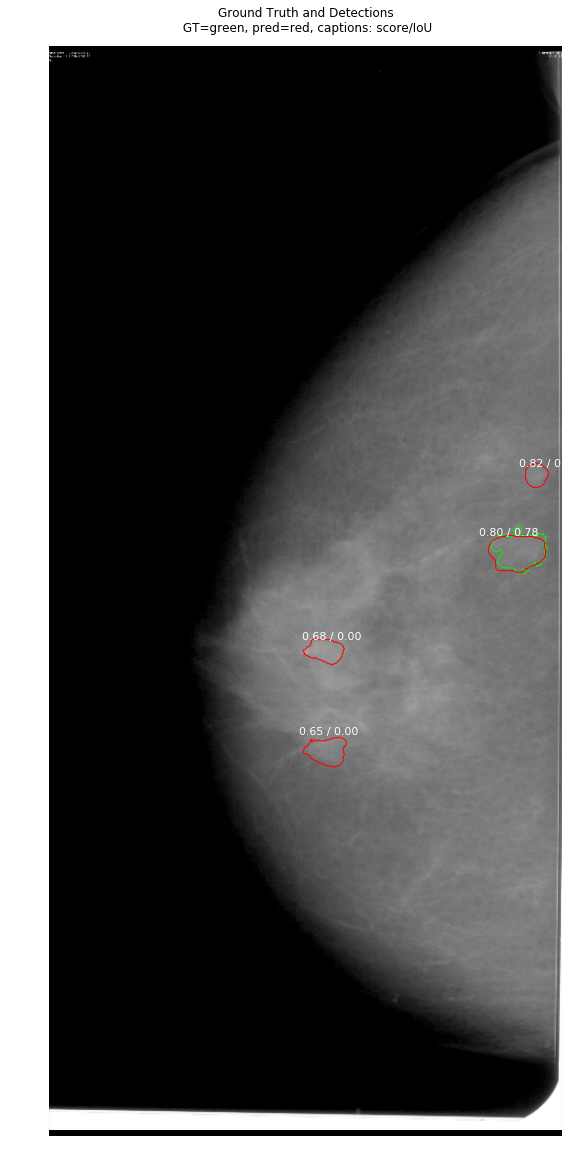

In [9]:
image_id = random.choice(dataset.image_ids)
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset.image_reference(image_id)))
print("Original image shape: ", modellib.parse_image_meta(image_meta[np.newaxis,...])["original_image_shape"][0])

# Run object detection
results = model.detect_molded(np.expand_dims(image, 0), np.expand_dims(image_meta, 0), verbose=1)

# Display results
r = results[0]
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

# # Compute AP over range 0.5 to 0.95 and print it
utils.compute_ap_range(gt_bbox, gt_class_id, gt_mask,
                       r['rois'], r['class_ids'], r['scores'], r['masks'],
                       verbose=1)

visualize.display_differences(
    image,
    gt_bbox, gt_class_id, gt_mask,
    r['rois'], r['class_ids'], r['scores'], r['masks'],
    dataset.class_names, ax=get_ax(),
    show_box=False, show_mask=False,
    iou_threshold=0.5, score_threshold=0.5)

In [9]:
# Path to a specific weights file
# weights_path = "/path/to/mask_rcnn_nucleus.h5"
pre = "mammo20180715T0134"
first = "mammo20180715T2144"
second = "mammo20180716T2155"
third = "mammo20180718T0053"
fourth = "mammo20180720T0204"
seventh = "mammo20180723T1241"

epochs_trained = 38
limit = 361

def compute_batch_ap(dataset, image_ids, verbose=1):
    APs = []
    for image_id in image_ids:
        # Load image
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset, config,
                                   image_id, use_mini_mask=False)
        # Run object detection
        results = model.detect_molded(image[np.newaxis], image_meta[np.newaxis], verbose=0)
        # Compute AP over range 0.5 to 0.95
        r = results[0]
        ap = utils.compute_ap_range(
            gt_bbox, gt_class_id, gt_mask,
            r['rois'], r['class_ids'], r['scores'], r['masks'],
            verbose=0)
        APs.append(ap)
        if verbose:
            info = dataset.image_info[image_id]
            meta = modellib.parse_image_meta(image_meta[np.newaxis,...])
            print("{:3} {}   AP: {:.2f}".format(
                meta["image_id"][0], meta["original_image_shape"][0], ap))
    return APs

for i in range(2, epochs_trained):
    if i < 10:
        n_epochs = "mask_rcnn_mammo_000" + str(i) + ".h5"
        weights_path = os.path.join(LOGS_DIR, seventh, n_epochs)
        print("Loading weights ", weights_path)
        model.load_weights(weights_path, by_name=True) 
        APs = compute_batch_ap(dataset, dataset.image_ids[:limit],verbose=0)
        print("Mean AP overa {} images: {:.4f}".format(len(APs), np.mean(APs)))
    elif i >= 10:
        n_epochs = "mask_rcnn_mammo_00" + str(i) + ".h5"
        weights_path = os.path.join(LOGS_DIR, seventh, n_epochs)
        print("Loading weights ", weights_path)
        model.load_weights(weights_path, by_name=True)       
        APs = compute_batch_ap(dataset, dataset.image_ids[:limit], verbose=0)
        print("Mean AP overa {} images: {:.4f}".format(len(APs), np.mean(APs)))
        
# Run on validation set

Loading weights  C:\Users\Chevy\Documents\GitHub\Mammo_MaskRCNN\mammography\checkpoints\mammo20180723T1241\mask_rcnn_mammo_0002.h5
Mean AP overa 361 images: 0.0110
Loading weights  C:\Users\Chevy\Documents\GitHub\Mammo_MaskRCNN\mammography\checkpoints\mammo20180723T1241\mask_rcnn_mammo_0003.h5
Mean AP overa 361 images: 0.0419
Loading weights  C:\Users\Chevy\Documents\GitHub\Mammo_MaskRCNN\mammography\checkpoints\mammo20180723T1241\mask_rcnn_mammo_0004.h5
Mean AP overa 361 images: 0.1094
Loading weights  C:\Users\Chevy\Documents\GitHub\Mammo_MaskRCNN\mammography\checkpoints\mammo20180723T1241\mask_rcnn_mammo_0005.h5
Mean AP overa 361 images: 0.0307
Loading weights  C:\Users\Chevy\Documents\GitHub\Mammo_MaskRCNN\mammography\checkpoints\mammo20180723T1241\mask_rcnn_mammo_0006.h5
Mean AP overa 361 images: 0.0292
Loading weights  C:\Users\Chevy\Documents\GitHub\Mammo_MaskRCNN\mammography\checkpoints\mammo20180723T1241\mask_rcnn_mammo_0007.h5
Mean AP overa 361 images: 0.0550
Loading weights 

In [10]:
# Path to a specific weights file
# weights_path = "/path/to/mask_rcnn_nucleus.h5"
pre = "mammo20180715T0134"
first = "mammo20180715T2144"
second = "mammo20180716T2155"
third = "mammo20180718T0053"
fourth = "mammo20180720T0204"
sixth = "mammo20180723T0300"
seventh = "mammo20180723T1241"

epochs_trained = 45
limit = 361

def compute_batch_ap(dataset, image_ids, verbose=1):
    APs = []
    for image_id in image_ids:
        # Load image
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset, config,
                                   image_id, use_mini_mask=False)
        # Run object detection
        results = model.detect_molded(image[np.newaxis], image_meta[np.newaxis], verbose=0)
        # Compute AP over range 0.5 to 0.95
        r = results[0]
        ap = utils.compute_ap_range(
            gt_bbox, gt_class_id, gt_mask,
            r['rois'], r['class_ids'], r['scores'], r['masks'],
            verbose=0)
        APs.append(ap)
        if verbose:
            info = dataset.image_info[image_id]
            meta = modellib.parse_image_meta(image_meta[np.newaxis,...])
            print("{:3} {}   AP: {:.2f}".format(
                meta["image_id"][0], meta["original_image_shape"][0], ap))
    return APs

for i in range(2, epochs_trained):
    if i < 10:
        n_epochs = "mask_rcnn_mammo_000" + str(i) + ".h5"
        weights_path = os.path.join(LOGS_DIR, sixth, n_epochs)
        print("Loading weights ", weights_path)
        model.load_weights(weights_path, by_name=True) 
        APs = compute_batch_ap(dataset, dataset.image_ids[:limit],verbose=0)
        print("Mean AP overa {} images: {:.4f}".format(len(APs), np.mean(APs)))
    elif i >= 10:
        n_epochs = "mask_rcnn_mammo_00" + str(i) + ".h5"
        weights_path = os.path.join(LOGS_DIR, sixth, n_epochs)
        print("Loading weights ", weights_path)
        model.load_weights(weights_path, by_name=True)       
        APs = compute_batch_ap(dataset, dataset.image_ids[:limit], verbose=0)
        print("Mean AP overa {} images: {:.4f}".format(len(APs), np.mean(APs)))
        
# Run on validation set

Loading weights  C:\Users\Chevy\Documents\GitHub\Mammo_MaskRCNN\mammography\checkpoints\mammo20180723T0300\mask_rcnn_mammo_0002.h5
Mean AP overa 361 images: 0.0773
Loading weights  C:\Users\Chevy\Documents\GitHub\Mammo_MaskRCNN\mammography\checkpoints\mammo20180723T0300\mask_rcnn_mammo_0003.h5
Mean AP overa 361 images: 0.1091
Loading weights  C:\Users\Chevy\Documents\GitHub\Mammo_MaskRCNN\mammography\checkpoints\mammo20180723T0300\mask_rcnn_mammo_0004.h5
Mean AP overa 361 images: 0.0801
Loading weights  C:\Users\Chevy\Documents\GitHub\Mammo_MaskRCNN\mammography\checkpoints\mammo20180723T0300\mask_rcnn_mammo_0005.h5
Mean AP overa 361 images: 0.1718
Loading weights  C:\Users\Chevy\Documents\GitHub\Mammo_MaskRCNN\mammography\checkpoints\mammo20180723T0300\mask_rcnn_mammo_0006.h5
Mean AP overa 361 images: 0.0942
Loading weights  C:\Users\Chevy\Documents\GitHub\Mammo_MaskRCNN\mammography\checkpoints\mammo20180723T0300\mask_rcnn_mammo_0007.h5
Mean AP overa 361 images: 0.0807
Loading weights 

KeyboardInterrupt: 

In [14]:
# Path to a specific weights file
# weights_path = "/path/to/mask_rcnn_nucleus.h5"
pre = "mammo20180715T0134"
first = "mammo20180715T2144"
second = "mammo20180716T2155"
third = "mammo20180718T0053"
fourth = "mammo20180720T0204"

epochs_trained = 40
limit = 361

def compute_batch_ap(dataset, image_ids, verbose=1):
    APs = []
    for image_id in image_ids:
        # Load image
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset, config,
                                   image_id, use_mini_mask=False)
        # Run object detection
        results = model.detect_molded(image[np.newaxis], image_meta[np.newaxis], verbose=0)
        # Compute AP over range 0.5 to 0.95
        r = results[0]
        ap = utils.compute_ap_range(
            gt_bbox, gt_class_id, gt_mask,
            r['rois'], r['class_ids'], r['scores'], r['masks'],
            verbose=0)
        APs.append(ap)
        if verbose:
            info = dataset.image_info[image_id]
            meta = modellib.parse_image_meta(image_meta[np.newaxis,...])
            print("{:3} {}   AP: {:.2f}".format(
                meta["image_id"][0], meta["original_image_shape"][0], ap))
    return APs

for i in range(10, epochs_trained+1):
    if i < 10:
        n_epochs = "mask_rcnn_mammo_000" + str(i) + ".h5"
        weights_path = os.path.join(LOGS_DIR, pre, n_epochs)
        print("Loading weights ", weights_path)
        model.load_weights(weights_path, by_name=True) 
        APs = compute_batch_ap(dataset, dataset.image_ids[:limit],verbose=0)
        print("Mean AP overa {} images: {:.4f}".format(len(APs), np.mean(APs)))
    elif i >= 10:
        n_epochs = "mask_rcnn_mammo_00" + str(i) + ".h5"
        weights_path = os.path.join(LOGS_DIR, pre, n_epochs)
        print("Loading weights ", weights_path)
        model.load_weights(weights_path, by_name=True)       
        APs = compute_batch_ap(dataset, dataset.image_ids[:limit], verbose=0)
        print("Mean AP overa {} images: {:.4f}".format(len(APs), np.mean(APs)))
        
# Run on validation set

Loading weights  C:\Users\Chevy\Documents\GitHub\Mammo_MaskRCNN\mammography\checkpoints\mammo20180715T0134\mask_rcnn_mammo_0010.h5
Mean AP overa 361 images: 0.2230
Loading weights  C:\Users\Chevy\Documents\GitHub\Mammo_MaskRCNN\mammography\checkpoints\mammo20180715T0134\mask_rcnn_mammo_0011.h5
Mean AP overa 361 images: 0.2077
Loading weights  C:\Users\Chevy\Documents\GitHub\Mammo_MaskRCNN\mammography\checkpoints\mammo20180715T0134\mask_rcnn_mammo_0012.h5
Mean AP overa 361 images: 0.2797
Loading weights  C:\Users\Chevy\Documents\GitHub\Mammo_MaskRCNN\mammography\checkpoints\mammo20180715T0134\mask_rcnn_mammo_0013.h5
Mean AP overa 361 images: 0.2775
Loading weights  C:\Users\Chevy\Documents\GitHub\Mammo_MaskRCNN\mammography\checkpoints\mammo20180715T0134\mask_rcnn_mammo_0014.h5
Mean AP overa 361 images: 0.2810
Loading weights  C:\Users\Chevy\Documents\GitHub\Mammo_MaskRCNN\mammography\checkpoints\mammo20180715T0134\mask_rcnn_mammo_0015.h5
Mean AP overa 361 images: 0.2353
Loading weights 

In [16]:
# Path to a specific weights file
# weights_path = "/path/to/mask_rcnn_nucleus.h5"
pre = "mammo20180715T0134"
first = "mammo20180715T2144"
second = "mammo20180716T2155"
third = "mammo20180718T0053"
fourth = "mammo20180720T0204"

epochs_trained = 40
limit = 361

def compute_batch_ap(dataset, image_ids, verbose=1):
    APs = []
    for image_id in image_ids:
        # Load image
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset, config,
                                   image_id, use_mini_mask=False)
        # Run object detection
        results = model.detect_molded(image[np.newaxis], image_meta[np.newaxis], verbose=0)
        # Compute AP over range 0.5 to 0.95
        r = results[0]
        ap = utils.compute_ap_range(
            gt_bbox, gt_class_id, gt_mask,
            r['rois'], r['class_ids'], r['scores'], r['masks'],
            verbose=0)
        APs.append(ap)
        if verbose:
            info = dataset.image_info[image_id]
            meta = modellib.parse_image_meta(image_meta[np.newaxis,...])
            print("{:3} {}   AP: {:.2f}".format(
                meta["image_id"][0], meta["original_image_shape"][0], ap))
    return APs

for i in range(2, epochs_trained+1):
    if i < 10:
        n_epochs = "mask_rcnn_mammo_000" + str(i) + ".h5"
        weights_path = os.path.join(LOGS_DIR, fourth, n_epochs)
        print("Loading weights ", weights_path)
        model.load_weights(weights_path, by_name=True) 
        APs = compute_batch_ap(dataset, dataset.image_ids[:limit],verbose=0)
        print("Mean AP overa {} images: {:.4f}".format(len(APs), np.mean(APs)))
    elif i >= 10:
        n_epochs = "mask_rcnn_mammo_00" + str(i) + ".h5"
        weights_path = os.path.join(LOGS_DIR, fourth, n_epochs)
        print("Loading weights ", weights_path)
        model.load_weights(weights_path, by_name=True)       
        APs = compute_batch_ap(dataset, dataset.image_ids[:limit], verbose=0)
        print("Mean AP overa {} images: {:.4f}".format(len(APs), np.mean(APs)))
        
# Run on validation set

Loading weights  C:\Users\Chevy\Documents\GitHub\Mammo_MaskRCNN\mammography\checkpoints\mammo20180720T0204\mask_rcnn_mammo_0002.h5
Mean AP overa 361 images: 0.0982
Loading weights  C:\Users\Chevy\Documents\GitHub\Mammo_MaskRCNN\mammography\checkpoints\mammo20180720T0204\mask_rcnn_mammo_0003.h5
Mean AP overa 361 images: 0.0957
Loading weights  C:\Users\Chevy\Documents\GitHub\Mammo_MaskRCNN\mammography\checkpoints\mammo20180720T0204\mask_rcnn_mammo_0004.h5
Mean AP overa 361 images: 0.1661
Loading weights  C:\Users\Chevy\Documents\GitHub\Mammo_MaskRCNN\mammography\checkpoints\mammo20180720T0204\mask_rcnn_mammo_0005.h5
Mean AP overa 361 images: 0.1284
Loading weights  C:\Users\Chevy\Documents\GitHub\Mammo_MaskRCNN\mammography\checkpoints\mammo20180720T0204\mask_rcnn_mammo_0006.h5
Mean AP overa 361 images: 0.1969
Loading weights  C:\Users\Chevy\Documents\GitHub\Mammo_MaskRCNN\mammography\checkpoints\mammo20180720T0204\mask_rcnn_mammo_0007.h5
Mean AP overa 361 images: 0.1908
Loading weights 

In [17]:
# Path to a specific weights file
# weights_path = "/path/to/mask_rcnn_nucleus.h5"
pre = "mammo20180715T0134"
first = "mammo20180715T2144"
second = "mammo20180716T2155"
third = "mammo20180718T0053"
fourth = "mammo20180720T0204"

epochs_trained = 40
limit = 361

def compute_batch_ap(dataset, image_ids, verbose=1):
    APs = []
    for image_id in image_ids:
        # Load image
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset, config,
                                   image_id, use_mini_mask=False)
        # Run object detection
        results = model.detect_molded(image[np.newaxis], image_meta[np.newaxis], verbose=0)
        # Compute AP over range 0.5 to 0.95
        r = results[0]
        ap = utils.compute_ap_range(
            gt_bbox, gt_class_id, gt_mask,
            r['rois'], r['class_ids'], r['scores'], r['masks'],
            verbose=0)
        APs.append(ap)
        if verbose:
            info = dataset.image_info[image_id]
            meta = modellib.parse_image_meta(image_meta[np.newaxis,...])
            print("{:3} {}   AP: {:.2f}".format(
                meta["image_id"][0], meta["original_image_shape"][0], ap))
    return APs

for i in range(2, epochs_trained+1):
    if i < 10:
        n_epochs = "mask_rcnn_mammo_000" + str(i) + ".h5"
        weights_path = os.path.join(LOGS_DIR, third, n_epochs)
        print("Loading weights ", weights_path)
        model.load_weights(weights_path, by_name=True) 
        APs = compute_batch_ap(dataset, dataset.image_ids[:limit],verbose=0)
        print("Mean AP overa {} images: {:.4f}".format(len(APs), np.mean(APs)))
    elif i >= 10:
        n_epochs = "mask_rcnn_mammo_00" + str(i) + ".h5"
        weights_path = os.path.join(LOGS_DIR, third, n_epochs)
        print("Loading weights ", weights_path)
        model.load_weights(weights_path, by_name=True)       
        APs = compute_batch_ap(dataset, dataset.image_ids[:limit], verbose=0)
        print("Mean AP overa {} images: {:.4f}".format(len(APs), np.mean(APs)))
        
# Run on validation set

Loading weights  C:\Users\Chevy\Documents\GitHub\Mammo_MaskRCNN\mammography\checkpoints\mammo20180718T0053\mask_rcnn_mammo_0002.h5
Mean AP overa 361 images: 0.0650
Loading weights  C:\Users\Chevy\Documents\GitHub\Mammo_MaskRCNN\mammography\checkpoints\mammo20180718T0053\mask_rcnn_mammo_0003.h5
Mean AP overa 361 images: 0.0745
Loading weights  C:\Users\Chevy\Documents\GitHub\Mammo_MaskRCNN\mammography\checkpoints\mammo20180718T0053\mask_rcnn_mammo_0004.h5
Mean AP overa 361 images: 0.1105
Loading weights  C:\Users\Chevy\Documents\GitHub\Mammo_MaskRCNN\mammography\checkpoints\mammo20180718T0053\mask_rcnn_mammo_0005.h5
Mean AP overa 361 images: 0.1942
Loading weights  C:\Users\Chevy\Documents\GitHub\Mammo_MaskRCNN\mammography\checkpoints\mammo20180718T0053\mask_rcnn_mammo_0006.h5
Mean AP overa 361 images: 0.2181
Loading weights  C:\Users\Chevy\Documents\GitHub\Mammo_MaskRCNN\mammography\checkpoints\mammo20180718T0053\mask_rcnn_mammo_0007.h5
Mean AP overa 361 images: 0.1912
Loading weights 

In [33]:
## Pre with 20 epochs
def compute_batch_ap(dataset, image_ids, verbose=1):
    APs = []
    for image_id in image_ids:
        # Load image
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset, config,
                                   image_id, use_mini_mask=False)
        # Run object detection
        results = model.detect_molded(image[np.newaxis], image_meta[np.newaxis], verbose=0)
        # Compute AP over range 0.5 to 0.95
        r = results[0]
        ap = utils.compute_ap_range(
            gt_bbox, gt_class_id, gt_mask,
            r['rois'], r['class_ids'], r['scores'], r['masks'],
            verbose=0)
        APs.append(ap)
        if verbose:
            info = dataset.image_info[image_id]
            meta = modellib.parse_image_meta(image_meta[np.newaxis,...])
            print("{:3} {}   AP: {:.2f}".format(
                meta["image_id"][0], meta["original_image_shape"][0], ap))
    return APs

# Run on validation set
limit = 361
APs = compute_batch_ap(dataset, dataset.image_ids[:limit])
print("Mean AP overa {} images: {:.4f}".format(len(APs), np.mean(APs)))

  0 [1024  471    3]   AP: 0.60
  1 [1024  375    3]   AP: 0.10
  2 [1024  555    3]   AP: 0.80
  3 [1024  576    3]   AP: 0.50
  4 [1024  528    3]   AP: 0.00
  5 [1024  525    3]   AP: 0.10
  6 [1024  652    3]   AP: 0.00
  7 [1024  646    3]   AP: 0.03
  8 [1024  699    3]   AP: 0.00
  9 [1024  501    3]   AP: 0.30
 10 [1024  454    3]   AP: 0.00
 11 [1024  685    3]   AP: 0.15
 12 [1024  649    3]   AP: 0.40
 13 [1024  712    3]   AP: 0.07
 14 [1024  642    3]   AP: 0.00
 15 [1024  700    3]   AP: 0.40
 16 [1024  713    3]   AP: 0.60
 17 [1024  512    3]   AP: 0.80
 18 [1024  453    3]   AP: 0.15
 19 [1024  486    3]   AP: 0.30
 20 [1024  707    3]   AP: 0.60
 21 [1024  710    3]   AP: 0.20
 22 [1024  417    3]   AP: 0.40
 23 [1024  504    3]   AP: 0.10
 24 [1024  673    3]   AP: 0.70
 25 [1024  602    3]   AP: 0.80
 26 [1024  655    3]   AP: 0.00
 27 [1024  635    3]   AP: 0.00
 28 [1024  735    3]   AP: 0.05
 29 [1024  533    3]   AP: 0.00
 30 [1024  559    3]   AP: 0.00
 31 [102

257 [1024  533    3]   AP: 0.30
258 [1024  500    3]   AP: 0.80
259 [1024  673    3]   AP: 0.03
260 [1024  669    3]   AP: 0.00
261 [1024  458    3]   AP: 0.00
262 [1024  387    3]   AP: 0.00
263 [1024  516    3]   AP: 0.50
264 [1024  552    3]   AP: 0.07
265 [1024  688    3]   AP: 0.00
266 [1024  546    3]   AP: 0.10
267 [1024  521    3]   AP: 0.70
268 [1024  566    3]   AP: 0.00
269 [1024  590    3]   AP: 0.60
270 [1024  593    3]   AP: 0.00
271 [1024  743    3]   AP: 0.00
272 [1024  734    3]   AP: 0.00
273 [1024  641    3]   AP: 0.00
274 [1024  644    3]   AP: 0.00
275 [1024  667    3]   AP: 0.30
276 [1024  675    3]   AP: 0.60
277 [1024  677    3]   AP: 0.10
278 [1024  700    3]   AP: 0.70
279 [1024  581    3]   AP: 0.20
280 [1024  628    3]   AP: 0.70
281 [1024  681    3]   AP: 0.60
282 [1024  576    3]   AP: 0.00
283 [1024  587    3]   AP: 0.00
284 [1024  512    3]   AP: 0.00
285 [1024  501    3]   AP: 0.00
286 [1024  536    3]   AP: 0.00
287 [1024  554    3]   AP: 0.00
288 [102

In [31]:
## Pre with 20 epochs
def compute_batch_ap(dataset, image_ids, verbose=1):
    APs = []
    for image_id in image_ids:
        # Load image
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset, config,
                                   image_id, use_mini_mask=False)
        # Run object detection
        results = model.detect_molded(image[np.newaxis], image_meta[np.newaxis], verbose=0)
        # Compute AP over range 0.5 to 0.95
        r = results[0]
        ap = utils.compute_ap_range(
            gt_bbox, gt_class_id, gt_mask,
            r['rois'], r['class_ids'], r['scores'], r['masks'],
            verbose=0)
        APs.append(ap)
        if verbose:
            info = dataset.image_info[image_id]
            meta = modellib.parse_image_meta(image_meta[np.newaxis,...])
            print("{:3} {}   AP: {:.2f}".format(
                meta["image_id"][0], meta["original_image_shape"][0], ap))
    return APs

# Run on validation set
limit = 361
APs = compute_batch_ap(dataset, dataset.image_ids[:limit])
print("Mean AP overa {} images: {:.4f}".format(len(APs), np.mean(APs)))

  0 [1024  471    3]   AP: 0.20
  1 [1024  375    3]   AP: 0.13
  2 [1024  555    3]   AP: 0.40
  3 [1024  576    3]   AP: 0.60
  4 [1024  528    3]   AP: 0.00
  5 [1024  525    3]   AP: 0.10
  6 [1024  652    3]   AP: 0.00
  7 [1024  646    3]   AP: 0.02
  8 [1024  699    3]   AP: 0.40
  9 [1024  501    3]   AP: 0.30
 10 [1024  454    3]   AP: 0.20
 11 [1024  685    3]   AP: 0.60
 12 [1024  649    3]   AP: 0.60
 13 [1024  712    3]   AP: 0.17
 14 [1024  642    3]   AP: 0.05
 15 [1024  700    3]   AP: 0.60
 16 [1024  713    3]   AP: 0.70
 17 [1024  512    3]   AP: 0.40
 18 [1024  453    3]   AP: 0.50
 19 [1024  486    3]   AP: 0.30
 20 [1024  707    3]   AP: 0.80
 21 [1024  710    3]   AP: 0.40
 22 [1024  417    3]   AP: 0.40
 23 [1024  504    3]   AP: 0.10
 24 [1024  673    3]   AP: 0.50
 25 [1024  602    3]   AP: 0.40
 26 [1024  655    3]   AP: 0.20
 27 [1024  635    3]   AP: 0.00
 28 [1024  735    3]   AP: 0.10
 29 [1024  533    3]   AP: 0.00
 30 [1024  559    3]   AP: 0.00
 31 [102

257 [1024  533    3]   AP: 0.35
258 [1024  500    3]   AP: 0.30
259 [1024  673    3]   AP: 0.05
260 [1024  669    3]   AP: 0.10
261 [1024  458    3]   AP: 0.00
262 [1024  387    3]   AP: 0.05
263 [1024  516    3]   AP: 0.30
264 [1024  552    3]   AP: 0.12
265 [1024  688    3]   AP: 0.20
266 [1024  546    3]   AP: 0.20
267 [1024  521    3]   AP: 0.70
268 [1024  566    3]   AP: 0.20
269 [1024  590    3]   AP: 0.20
270 [1024  593    3]   AP: 0.00
271 [1024  743    3]   AP: 0.05
272 [1024  734    3]   AP: 0.05
273 [1024  641    3]   AP: 0.00
274 [1024  644    3]   AP: 0.10
275 [1024  667    3]   AP: 0.60
276 [1024  675    3]   AP: 0.70
277 [1024  677    3]   AP: 0.20
278 [1024  700    3]   AP: 0.70
279 [1024  581    3]   AP: 0.13
280 [1024  628    3]   AP: 0.70
281 [1024  681    3]   AP: 0.70
282 [1024  576    3]   AP: 0.00
283 [1024  587    3]   AP: 0.00
284 [1024  512    3]   AP: 0.20
285 [1024  501    3]   AP: 0.30
286 [1024  536    3]   AP: 0.00
287 [1024  554    3]   AP: 0.06
288 [102

In [29]:
## Pre with 25 epochs
def compute_batch_ap(dataset, image_ids, verbose=1):
    APs = []
    for image_id in image_ids:
        # Load image
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset, config,
                                   image_id, use_mini_mask=False)
        # Run object detection
        results = model.detect_molded(image[np.newaxis], image_meta[np.newaxis], verbose=0)
        # Compute AP over range 0.5 to 0.95
        r = results[0]
        ap = utils.compute_ap_range(
            gt_bbox, gt_class_id, gt_mask,
            r['rois'], r['class_ids'], r['scores'], r['masks'],
            verbose=0)
        APs.append(ap)
        if verbose:
            info = dataset.image_info[image_id]
            meta = modellib.parse_image_meta(image_meta[np.newaxis,...])
            print("{:3} {}   AP: {:.2f}".format(
                meta["image_id"][0], meta["original_image_shape"][0], ap))
    return APs

# Run on validation set
limit = 361
APs = compute_batch_ap(dataset, dataset.image_ids[:limit])
print("Mean AP overa {} images: {:.4f}".format(len(APs), np.mean(APs)))

  0 [1024  471    3]   AP: 0.50
  1 [1024  375    3]   AP: 0.00
  2 [1024  555    3]   AP: 0.70
  3 [1024  576    3]   AP: 0.70
  4 [1024  528    3]   AP: 0.00
  5 [1024  525    3]   AP: 0.20
  6 [1024  652    3]   AP: 0.10
  7 [1024  646    3]   AP: 0.05
  8 [1024  699    3]   AP: 0.00
  9 [1024  501    3]   AP: 0.25
 10 [1024  454    3]   AP: 0.00
 11 [1024  685    3]   AP: 0.15
 12 [1024  649    3]   AP: 0.20
 13 [1024  712    3]   AP: 0.00
 14 [1024  642    3]   AP: 0.10
 15 [1024  700    3]   AP: 0.50
 16 [1024  713    3]   AP: 0.60
 17 [1024  512    3]   AP: 0.50
 18 [1024  453    3]   AP: 0.50
 19 [1024  486    3]   AP: 0.50
 20 [1024  707    3]   AP: 0.60
 21 [1024  710    3]   AP: 0.30
 22 [1024  417    3]   AP: 0.40
 23 [1024  504    3]   AP: 0.00
 24 [1024  673    3]   AP: 0.60
 25 [1024  602    3]   AP: 0.70
 26 [1024  655    3]   AP: 0.00
 27 [1024  635    3]   AP: 0.00
 28 [1024  735    3]   AP: 0.10
 29 [1024  533    3]   AP: 0.00
 30 [1024  559    3]   AP: 0.00
 31 [102

257 [1024  533    3]   AP: 0.60
258 [1024  500    3]   AP: 0.70
259 [1024  673    3]   AP: 0.00
260 [1024  669    3]   AP: 0.20
261 [1024  458    3]   AP: 0.00
262 [1024  387    3]   AP: 0.00
263 [1024  516    3]   AP: 0.40
264 [1024  552    3]   AP: 0.04
265 [1024  688    3]   AP: 0.20
266 [1024  546    3]   AP: 0.10
267 [1024  521    3]   AP: 0.60
268 [1024  566    3]   AP: 0.05
269 [1024  590    3]   AP: 0.30
270 [1024  593    3]   AP: 0.00
271 [1024  743    3]   AP: 0.00
272 [1024  734    3]   AP: 0.00
273 [1024  641    3]   AP: 0.00
274 [1024  644    3]   AP: 0.00
275 [1024  667    3]   AP: 0.40
276 [1024  675    3]   AP: 0.80
277 [1024  677    3]   AP: 0.10
278 [1024  700    3]   AP: 0.70
279 [1024  581    3]   AP: 0.10
280 [1024  628    3]   AP: 0.70
281 [1024  681    3]   AP: 0.70
282 [1024  576    3]   AP: 0.00
283 [1024  587    3]   AP: 0.00
284 [1024  512    3]   AP: 0.00
285 [1024  501    3]   AP: 0.00
286 [1024  536    3]   AP: 0.00
287 [1024  554    3]   AP: 0.00
288 [102

In [27]:
## Pre with 30 epochs
def compute_batch_ap(dataset, image_ids, verbose=1):
    APs = []
    for image_id in image_ids:
        # Load image
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset, config,
                                   image_id, use_mini_mask=False)
        # Run object detection
        results = model.detect_molded(image[np.newaxis], image_meta[np.newaxis], verbose=0)
        # Compute AP over range 0.5 to 0.95
        r = results[0]
        ap = utils.compute_ap_range(
            gt_bbox, gt_class_id, gt_mask,
            r['rois'], r['class_ids'], r['scores'], r['masks'],
            verbose=0)
        APs.append(ap)
        if verbose:
            info = dataset.image_info[image_id]
            meta = modellib.parse_image_meta(image_meta[np.newaxis,...])
            print("{:3} {}   AP: {:.2f}".format(
                meta["image_id"][0], meta["original_image_shape"][0], ap))
    return APs

# Run on validation set
limit = 361
APs = compute_batch_ap(dataset, dataset.image_ids[:limit])
print("Mean AP overa {} images: {:.4f}".format(len(APs), np.mean(APs)))

  0 [1024  471    3]   AP: 0.40
  1 [1024  375    3]   AP: 0.03
  2 [1024  555    3]   AP: 0.50
  3 [1024  576    3]   AP: 0.30
  4 [1024  528    3]   AP: 0.00
  5 [1024  525    3]   AP: 0.20
  6 [1024  652    3]   AP: 0.10
  7 [1024  646    3]   AP: 0.07
  8 [1024  699    3]   AP: 0.15
  9 [1024  501    3]   AP: 0.60
 10 [1024  454    3]   AP: 0.10
 11 [1024  685    3]   AP: 0.50
 12 [1024  649    3]   AP: 0.70
 13 [1024  712    3]   AP: 0.07
 14 [1024  642    3]   AP: 0.15
 15 [1024  700    3]   AP: 0.60
 16 [1024  713    3]   AP: 0.70
 17 [1024  512    3]   AP: 0.30
 18 [1024  453    3]   AP: 0.60
 19 [1024  486    3]   AP: 0.60
 20 [1024  707    3]   AP: 0.90
 21 [1024  710    3]   AP: 0.50
 22 [1024  417    3]   AP: 0.40
 23 [1024  504    3]   AP: 0.00
 24 [1024  673    3]   AP: 0.30
 25 [1024  602    3]   AP: 0.30
 26 [1024  655    3]   AP: 0.00
 27 [1024  635    3]   AP: 0.00
 28 [1024  735    3]   AP: 0.10
 29 [1024  533    3]   AP: 0.00
 30 [1024  559    3]   AP: 0.00
 31 [102

257 [1024  533    3]   AP: 0.35
258 [1024  500    3]   AP: 0.25
259 [1024  673    3]   AP: 0.05
260 [1024  669    3]   AP: 0.20
261 [1024  458    3]   AP: 0.00
262 [1024  387    3]   AP: 0.10
263 [1024  516    3]   AP: 0.40
264 [1024  552    3]   AP: 0.15
265 [1024  688    3]   AP: 0.06
266 [1024  546    3]   AP: 0.00
267 [1024  521    3]   AP: 0.60
268 [1024  566    3]   AP: 0.10
269 [1024  590    3]   AP: 0.40
270 [1024  593    3]   AP: 0.00
271 [1024  743    3]   AP: 0.20
272 [1024  734    3]   AP: 0.10
273 [1024  641    3]   AP: 0.10
274 [1024  644    3]   AP: 0.05
275 [1024  667    3]   AP: 0.60
276 [1024  675    3]   AP: 0.70
277 [1024  677    3]   AP: 0.20
278 [1024  700    3]   AP: 0.70
279 [1024  581    3]   AP: 0.50
280 [1024  628    3]   AP: 0.70
281 [1024  681    3]   AP: 0.70
282 [1024  576    3]   AP: 0.00
283 [1024  587    3]   AP: 0.00
284 [1024  512    3]   AP: 0.00
285 [1024  501    3]   AP: 0.30
286 [1024  536    3]   AP: 0.00
287 [1024  554    3]   AP: 0.00
288 [102

In [25]:
## Pre with 35 epochs
def compute_batch_ap(dataset, image_ids, verbose=1):
    APs = []
    for image_id in image_ids:
        # Load image
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset, config,
                                   image_id, use_mini_mask=False)
        # Run object detection
        results = model.detect_molded(image[np.newaxis], image_meta[np.newaxis], verbose=0)
        # Compute AP over range 0.5 to 0.95
        r = results[0]
        ap = utils.compute_ap_range(
            gt_bbox, gt_class_id, gt_mask,
            r['rois'], r['class_ids'], r['scores'], r['masks'],
            verbose=0)
        APs.append(ap)
        if verbose:
            info = dataset.image_info[image_id]
            meta = modellib.parse_image_meta(image_meta[np.newaxis,...])
            print("{:3} {}   AP: {:.2f}".format(
                meta["image_id"][0], meta["original_image_shape"][0], ap))
    return APs

# Run on validation set
limit = 361
APs = compute_batch_ap(dataset, dataset.image_ids[:limit])
print("Mean AP overa {} images: {:.4f}".format(len(APs), np.mean(APs)))

  0 [1024  471    3]   AP: 0.60
  1 [1024  375    3]   AP: 0.15
  2 [1024  555    3]   AP: 0.50
  3 [1024  576    3]   AP: 0.60
  4 [1024  528    3]   AP: 0.00
  5 [1024  525    3]   AP: 0.05
  6 [1024  652    3]   AP: 0.03
  7 [1024  646    3]   AP: 0.00
  8 [1024  699    3]   AP: 0.40
  9 [1024  501    3]   AP: 0.50
 10 [1024  454    3]   AP: 0.03
 11 [1024  685    3]   AP: 0.60
 12 [1024  649    3]   AP: 0.50
 13 [1024  712    3]   AP: 0.10
 14 [1024  642    3]   AP: 0.07
 15 [1024  700    3]   AP: 0.60
 16 [1024  713    3]   AP: 0.60
 17 [1024  512    3]   AP: 0.40
 18 [1024  453    3]   AP: 0.70
 19 [1024  486    3]   AP: 0.50
 20 [1024  707    3]   AP: 0.80
 21 [1024  710    3]   AP: 0.40
 22 [1024  417    3]   AP: 0.20
 23 [1024  504    3]   AP: 0.00
 24 [1024  673    3]   AP: 0.50
 25 [1024  602    3]   AP: 0.40
 26 [1024  655    3]   AP: 0.00
 27 [1024  635    3]   AP: 0.00
 28 [1024  735    3]   AP: 0.07
 29 [1024  533    3]   AP: 0.00
 30 [1024  559    3]   AP: 0.00
 31 [102

257 [1024  533    3]   AP: 0.35
258 [1024  500    3]   AP: 0.35
259 [1024  673    3]   AP: 0.00
260 [1024  669    3]   AP: 0.10
261 [1024  458    3]   AP: 0.00
262 [1024  387    3]   AP: 0.00
263 [1024  516    3]   AP: 0.40
264 [1024  552    3]   AP: 0.08
265 [1024  688    3]   AP: 0.00
266 [1024  546    3]   AP: 0.00
267 [1024  521    3]   AP: 0.70
268 [1024  566    3]   AP: 0.10
269 [1024  590    3]   AP: 0.40
270 [1024  593    3]   AP: 0.00
271 [1024  743    3]   AP: 0.00
272 [1024  734    3]   AP: 0.05
273 [1024  641    3]   AP: 0.00
274 [1024  644    3]   AP: 0.10
275 [1024  667    3]   AP: 0.60
276 [1024  675    3]   AP: 0.70
277 [1024  677    3]   AP: 0.03
278 [1024  700    3]   AP: 0.70
279 [1024  581    3]   AP: 0.40
280 [1024  628    3]   AP: 0.70
281 [1024  681    3]   AP: 0.60
282 [1024  576    3]   AP: 0.00
283 [1024  587    3]   AP: 0.00
284 [1024  512    3]   AP: 0.00
285 [1024  501    3]   AP: 0.20
286 [1024  536    3]   AP: 0.00
287 [1024  554    3]   AP: 0.00
288 [102

In [23]:
### Pre with 40 epochs
def compute_batch_ap(dataset, image_ids, verbose=1):
    APs = []
    for image_id in image_ids:
        # Load image
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset, config,
                                   image_id, use_mini_mask=False)
        # Run object detection
        results = model.detect_molded(image[np.newaxis], image_meta[np.newaxis], verbose=0)
        # Compute AP over range 0.5 to 0.95
        r = results[0]
        ap = utils.compute_ap_range(
            gt_bbox, gt_class_id, gt_mask,
            r['rois'], r['class_ids'], r['scores'], r['masks'],
            verbose=0)
        APs.append(ap)
        if verbose:
            info = dataset.image_info[image_id]
            meta = modellib.parse_image_meta(image_meta[np.newaxis,...])
            print("{:3} {}   AP: {:.2f}".format(
                meta["image_id"][0], meta["original_image_shape"][0], ap))
    return APs

# Run on validation set
limit = 361
APs = compute_batch_ap(dataset, dataset.image_ids[:limit])
print("Mean AP overa {} images: {:.4f}".format(len(APs), np.mean(APs)))

  0 [1024  471    3]   AP: 0.30
  1 [1024  375    3]   AP: 0.00
  2 [1024  555    3]   AP: 0.30
  3 [1024  576    3]   AP: 0.60
  4 [1024  528    3]   AP: 0.00
  5 [1024  525    3]   AP: 0.00
  6 [1024  652    3]   AP: 0.00
  7 [1024  646    3]   AP: 0.00
  8 [1024  699    3]   AP: 0.50
  9 [1024  501    3]   AP: 0.23
 10 [1024  454    3]   AP: 0.10
 11 [1024  685    3]   AP: 0.60
 12 [1024  649    3]   AP: 0.70
 13 [1024  712    3]   AP: 0.20
 14 [1024  642    3]   AP: 0.15
 15 [1024  700    3]   AP: 0.60
 16 [1024  713    3]   AP: 0.60
 17 [1024  512    3]   AP: 0.40
 18 [1024  453    3]   AP: 0.60
 19 [1024  486    3]   AP: 0.70
 20 [1024  707    3]   AP: 0.80
 21 [1024  710    3]   AP: 0.50
 22 [1024  417    3]   AP: 0.00
 23 [1024  504    3]   AP: 0.00
 24 [1024  673    3]   AP: 0.40
 25 [1024  602    3]   AP: 0.40
 26 [1024  655    3]   AP: 0.00
 27 [1024  635    3]   AP: 0.00
 28 [1024  735    3]   AP: 0.00
 29 [1024  533    3]   AP: 0.00
 30 [1024  559    3]   AP: 0.00
 31 [102

257 [1024  533    3]   AP: 0.35
258 [1024  500    3]   AP: 0.30
259 [1024  673    3]   AP: 0.00
260 [1024  669    3]   AP: 0.20
261 [1024  458    3]   AP: 0.00
262 [1024  387    3]   AP: 0.00
263 [1024  516    3]   AP: 0.40
264 [1024  552    3]   AP: 0.00
265 [1024  688    3]   AP: 0.00
266 [1024  546    3]   AP: 0.00
267 [1024  521    3]   AP: 0.70
268 [1024  566    3]   AP: 0.10
269 [1024  590    3]   AP: 0.40
270 [1024  593    3]   AP: 0.00
271 [1024  743    3]   AP: 0.00
272 [1024  734    3]   AP: 0.00
273 [1024  641    3]   AP: 0.00
274 [1024  644    3]   AP: 0.10
275 [1024  667    3]   AP: 0.70
276 [1024  675    3]   AP: 0.70
277 [1024  677    3]   AP: 0.03
278 [1024  700    3]   AP: 0.80
279 [1024  581    3]   AP: 0.40
280 [1024  628    3]   AP: 0.70
281 [1024  681    3]   AP: 0.70
282 [1024  576    3]   AP: 0.00
283 [1024  587    3]   AP: 0.00
284 [1024  512    3]   AP: 0.00
285 [1024  501    3]   AP: 0.40
286 [1024  536    3]   AP: 0.00
287 [1024  554    3]   AP: 0.00
288 [102

## Fourth Training results on Mass-Test

In [11]:
def compute_batch_ap(dataset, image_ids, verbose=1):
    APs = []
    for image_id in image_ids:
        # Load image
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset, config,
                                   image_id, use_mini_mask=False)
        # Run object detection
        results = model.detect_molded(image[np.newaxis], image_meta[np.newaxis], verbose=0)
        # Compute AP over range 0.5 to 0.951
        r = results[0]
        ap = utils.compute_ap_range(
            gt_bbox, gt_class_id, gt_mask,
            r['rois'], r['class_ids'], r['scores'], r['masks'],
            verbose=0)
        APs.append(ap)
        if verbose:
            info = dataset.image_info[image_id]
            meta = modellib.parse_image_meta(image_meta[np.newaxis,...])
            print("{:3} {}   AP: {:.2f}".format(
                meta["image_id"][0], meta["original_image_shape"][0], ap))
    return APs

# Run on validation set
limit = 361
APs = compute_batch_ap(dataset, dataset.image_ids[:limit])
print("Mean AP overa {} images: {:.4f}".format(len(APs), np.mean(APs)))

  0 [1024  471    3]   AP: 0.40
  1 [1024  375    3]   AP: 0.30
  2 [1024  555    3]   AP: 0.00
  3 [1024  576    3]   AP: 0.00
  4 [1024  528    3]   AP: 0.00
  5 [1024  525    3]   AP: 0.00
  6 [1024  652    3]   AP: 0.00
  7 [1024  646    3]   AP: 0.00
  8 [1024  699    3]   AP: 0.20
  9 [1024  501    3]   AP: 0.00
 10 [1024  454    3]   AP: 0.00
 11 [1024  685    3]   AP: 0.50
 12 [1024  649    3]   AP: 0.40
 13 [1024  712    3]   AP: 0.03
 14 [1024  642    3]   AP: 0.00
 15 [1024  700    3]   AP: 0.50
 16 [1024  713    3]   AP: 0.00
 17 [1024  512    3]   AP: 0.60
 18 [1024  453    3]   AP: 0.00
 19 [1024  486    3]   AP: 0.00
 20 [1024  707    3]   AP: 0.90
 21 [1024  710    3]   AP: 0.50
 22 [1024  417    3]   AP: 0.00
 23 [1024  504    3]   AP: 0.00
 24 [1024  673    3]   AP: 0.50
 25 [1024  602    3]   AP: 0.60
 26 [1024  655    3]   AP: 0.00
 27 [1024  635    3]   AP: 0.00
 28 [1024  735    3]   AP: 0.00
 29 [1024  533    3]   AP: 0.00
 30 [1024  559    3]   AP: 0.00
 31 [102

257 [1024  533    3]   AP: 0.60
258 [1024  500    3]   AP: 0.00
259 [1024  673    3]   AP: 0.00
260 [1024  669    3]   AP: 0.00
261 [1024  458    3]   AP: 0.00
262 [1024  387    3]   AP: 0.00
263 [1024  516    3]   AP: 0.00
264 [1024  552    3]   AP: 0.30
265 [1024  688    3]   AP: 0.00
266 [1024  546    3]   AP: 0.50
267 [1024  521    3]   AP: 0.00
268 [1024  566    3]   AP: 0.10
269 [1024  590    3]   AP: 0.40
270 [1024  593    3]   AP: 0.00
271 [1024  743    3]   AP: 0.00
272 [1024  734    3]   AP: 0.00
273 [1024  641    3]   AP: 0.00
274 [1024  644    3]   AP: 0.00
275 [1024  667    3]   AP: 0.30
276 [1024  675    3]   AP: 0.60
277 [1024  677    3]   AP: 0.00
278 [1024  700    3]   AP: 0.70
279 [1024  581    3]   AP: 0.00
280 [1024  628    3]   AP: 0.00
281 [1024  681    3]   AP: 0.80
282 [1024  576    3]   AP: 0.00
283 [1024  587    3]   AP: 0.00
284 [1024  512    3]   AP: 0.00
285 [1024  501    3]   AP: 0.30
286 [1024  536    3]   AP: 0.00
287 [1024  554    3]   AP: 0.00
288 [102

## Third training results on Mass-Test

In [15]:
def compute_batch_ap(dataset, image_ids, verbose=1):
    APs = []
    for image_id in image_ids:
        # Load image
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset, config,
                                   image_id, use_mini_mask=False)
        # Run object detection
        results = model.detect_molded(image[np.newaxis], image_meta[np.newaxis], verbose=0)
        # Compute AP over range 0.5 to 0.95
        r = results[0]
        ap = utils.compute_ap_range(
            gt_bbox, gt_class_id, gt_mask,
            r['rois'], r['class_ids'], r['scores'], r['masks'],
            verbose=0)
        APs.append(ap)
        if verbose:
            info = dataset.image_info[image_id]
            meta = modellib.parse_image_meta(image_meta[np.newaxis,...])
            print("{:3} {}   AP: {:.2f}".format(
                meta["image_id"][0], meta["original_image_shape"][0], ap))
    return APs

# Run on validation set
limit = 361
APs = compute_batch_ap(dataset, dataset.image_ids[:limit])
print("Mean AP overa {} images: {:.4f}".format(len(APs), np.mean(APs)))

  0 [1024  471    3]   AP: 0.60
  1 [1024  375    3]   AP: 0.40
  2 [1024  555    3]   AP: 0.00
  3 [1024  576    3]   AP: 0.00
  4 [1024  528    3]   AP: 0.00
  5 [1024  525    3]   AP: 0.00
  6 [1024  652    3]   AP: 0.00
  7 [1024  646    3]   AP: 0.05
  8 [1024  699    3]   AP: 0.00
  9 [1024  501    3]   AP: 0.00
 10 [1024  454    3]   AP: 0.00
 11 [1024  685    3]   AP: 0.50
 12 [1024  649    3]   AP: 0.00
 13 [1024  712    3]   AP: 0.05
 14 [1024  642    3]   AP: 0.10
 15 [1024  700    3]   AP: 0.60
 16 [1024  713    3]   AP: 0.50
 17 [1024  512    3]   AP: 0.60
 18 [1024  453    3]   AP: 0.00
 19 [1024  486    3]   AP: 0.40
 20 [1024  707    3]   AP: 0.80
 21 [1024  710    3]   AP: 0.40
 22 [1024  417    3]   AP: 0.00
 23 [1024  504    3]   AP: 0.00
 24 [1024  673    3]   AP: 0.30
 25 [1024  602    3]   AP: 0.30
 26 [1024  655    3]   AP: 0.00
 27 [1024  635    3]   AP: 0.00
 28 [1024  735    3]   AP: 0.00
 29 [1024  533    3]   AP: 0.00
 30 [1024  559    3]   AP: 0.00
 31 [102

257 [1024  533    3]   AP: 0.60
258 [1024  500    3]   AP: 0.80
259 [1024  673    3]   AP: 0.00
260 [1024  669    3]   AP: 0.20
261 [1024  458    3]   AP: 0.00
262 [1024  387    3]   AP: 0.00
263 [1024  516    3]   AP: 0.00
264 [1024  552    3]   AP: 0.00
265 [1024  688    3]   AP: 0.00
266 [1024  546    3]   AP: 0.30
267 [1024  521    3]   AP: 0.70
268 [1024  566    3]   AP: 0.00
269 [1024  590    3]   AP: 0.30
270 [1024  593    3]   AP: 0.00
271 [1024  743    3]   AP: 0.00
272 [1024  734    3]   AP: 0.00
273 [1024  641    3]   AP: 0.00
274 [1024  644    3]   AP: 0.10
275 [1024  667    3]   AP: 0.35
276 [1024  675    3]   AP: 0.50
277 [1024  677    3]   AP: 0.00
278 [1024  700    3]   AP: 0.80
279 [1024  581    3]   AP: 0.50
280 [1024  628    3]   AP: 0.00
281 [1024  681    3]   AP: 0.70
282 [1024  576    3]   AP: 0.00
283 [1024  587    3]   AP: 0.00
284 [1024  512    3]   AP: 0.00
285 [1024  501    3]   AP: 0.20
286 [1024  536    3]   AP: 0.00
287 [1024  554    3]   AP: 0.00
288 [102

## First results on Mass-Train

In [18]:
def compute_batch_ap(dataset, image_ids, verbose=1):
    APs = []
    for image_id in image_ids:
        # Load image
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset, config,
                                   image_id, use_mini_mask=False)
        # Run object detection
        results = model.detect_molded(image[np.newaxis], image_meta[np.newaxis], verbose=0)
        # Compute AP over range 0.5 to 0.95
        r = results[0]
        ap = utils.compute_ap_range(
            gt_bbox, gt_class_id, gt_mask,
            r['rois'], r['class_ids'], r['scores'], r['masks'],
            verbose=0)
        APs.append(ap)
        if verbose:
            info = dataset.image_info[image_id]
            meta = modellib.parse_image_meta(image_meta[np.newaxis,...])
            print("{:3} {}   AP: {:.2f}".format(
                meta["image_id"][0], meta["original_image_shape"][0], ap))
    return APs

# Run on validation set
limit = 361
APs = compute_batch_ap(dataset, dataset.image_ids[:limit])
print("Mean AP overa {} images: {:.4f}".format(len(APs), np.mean(APs)))

  0 [1024  471    3]   AP: 0.60
  1 [1024  375    3]   AP: 0.50
  2 [1024  555    3]   AP: 0.60
  3 [1024  576    3]   AP: 0.50
  4 [1024  528    3]   AP: 0.00
  5 [1024  525    3]   AP: 0.00
  6 [1024  652    3]   AP: 0.00
  7 [1024  646    3]   AP: 0.00
  8 [1024  699    3]   AP: 0.00
  9 [1024  501    3]   AP: 0.00
 10 [1024  454    3]   AP: 0.00
 11 [1024  685    3]   AP: 0.40
 12 [1024  649    3]   AP: 0.30
 13 [1024  712    3]   AP: 0.15
 14 [1024  642    3]   AP: 0.05
 15 [1024  700    3]   AP: 0.50
 16 [1024  713    3]   AP: 0.60
 17 [1024  512    3]   AP: 0.60
 18 [1024  453    3]   AP: 0.50
 19 [1024  486    3]   AP: 0.15
 20 [1024  707    3]   AP: 0.80
 21 [1024  710    3]   AP: 0.30
 22 [1024  417    3]   AP: 0.00
 23 [1024  504    3]   AP: 0.00
 24 [1024  673    3]   AP: 0.60
 25 [1024  602    3]   AP: 0.70
 26 [1024  655    3]   AP: 0.00
 27 [1024  635    3]   AP: 0.00
 28 [1024  735    3]   AP: 0.00
 29 [1024  533    3]   AP: 0.00
 30 [1024  559    3]   AP: 0.00
 31 [102

257 [1024  533    3]   AP: 0.60
258 [1024  500    3]   AP: 0.70
259 [1024  673    3]   AP: 0.00
260 [1024  669    3]   AP: 0.00
261 [1024  458    3]   AP: 0.00
262 [1024  387    3]   AP: 0.00
263 [1024  516    3]   AP: 0.00
264 [1024  552    3]   AP: 0.00
265 [1024  688    3]   AP: 0.00
266 [1024  546    3]   AP: 0.07
267 [1024  521    3]   AP: 0.70
268 [1024  566    3]   AP: 0.00
269 [1024  590    3]   AP: 0.25
270 [1024  593    3]   AP: 0.00
271 [1024  743    3]   AP: 0.00
272 [1024  734    3]   AP: 0.00
273 [1024  641    3]   AP: 0.00
274 [1024  644    3]   AP: 0.00
275 [1024  667    3]   AP: 0.50
276 [1024  675    3]   AP: 0.60
277 [1024  677    3]   AP: 0.00
278 [1024  700    3]   AP: 0.80
279 [1024  581    3]   AP: 0.30
280 [1024  628    3]   AP: 0.00
281 [1024  681    3]   AP: 0.50
282 [1024  576    3]   AP: 0.00
283 [1024  587    3]   AP: 0.00
284 [1024  512    3]   AP: 0.00
285 [1024  501    3]   AP: 0.00
286 [1024  536    3]   AP: 0.00
287 [1024  554    3]   AP: 0.00
288 [102

image ID: nucleus.4193474b2f1c72f735b13633b219d9cabdd43c21d9c2bb4dfc4809f104ba4c06 (20) 4193474b2f1c72f735b13633b219d9cabdd43c21d9c2bb4dfc4809f104ba4c06
Original image shape:  [256 320   3]
Processing 1 images
image                    shape: (512, 640, 3)         min:    1.00000  max:  229.00000  uint8
molded_images            shape: (1, 512, 640, 3)      min:    1.00000  max:  229.00000  uint8
image_metas              shape: (1, 14)               min:    0.00000  max:  640.00000  float64
anchors                  shape: (1, 81840, 4)         min:   -0.17712  max:    1.05188  float32
gt_class_id              shape: (12,)                 min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (12, 4)               min:    4.00000  max:  588.00000  int32
gt_mask                  shape: (512, 640, 12)        min:    0.00000  max:    1.00000  bool
AP @0.50:	 0.903
AP @0.55:	 0.903
AP @0.60:	 0.903
AP @0.65:	 0.787
AP @0.70:	 0.354
AP @0.75:	 0.354
AP @0.80:	 0.167
AP @0.85:	

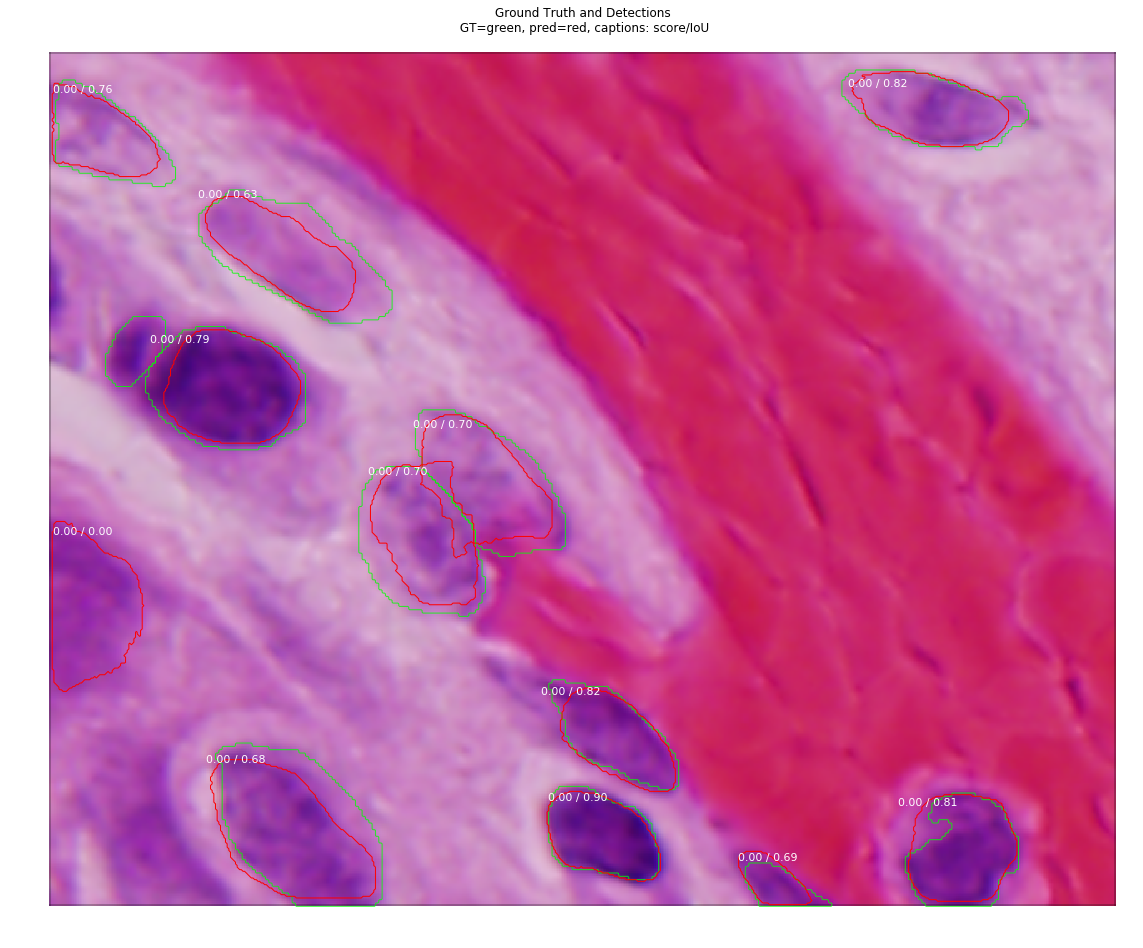

In [9]:
image_id = random.choice(dataset.image_ids)
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset.image_reference(image_id)))
print("Original image shape: ", modellib.parse_image_meta(image_meta[np.newaxis,...])["original_image_shape"][0])

# Run object detection
results = model.detect_molded(np.expand_dims(image, 0), np.expand_dims(image_meta, 0), verbose=1)

# Display results
r = results[0]
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

# Compute AP over range 0.5 to 0.95 and print it
utils.compute_ap_range(gt_bbox, gt_class_id, gt_mask,
                       r['rois'], r['class_ids'], r['scores'], r['masks'],
                       verbose=1)

visualize.display_differences(
    image,
    gt_bbox, gt_class_id, gt_mask,
    r['rois'], r['class_ids'], r['scores'], r['masks'],
    dataset.class_names, ax=get_ax(),
    show_box=False, show_mask=False,
    iou_threshold=0.5, score_threshold=0.5)

In [10]:
# Display predictions only
# visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
#                             dataset.class_names, r['scores'], ax=get_ax(1),
#                             show_bbox=False, show_mask=False,
#                             title="Predictions")

In [11]:
# Display Ground Truth only
# visualize.display_instances(image, gt_bbox, gt_mask, gt_class_id, 
#                             dataset.class_names, ax=get_ax(1),
#                             show_bbox=False, show_mask=False,
#                             title="Ground Truth")

### Compute AP on Batch of Images

In [12]:
def compute_batch_ap(dataset, image_ids, verbose=1):
    APs = []
    for image_id in image_ids:
        # Load image
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset, config,
                                   image_id, use_mini_mask=False)
        # Run object detection
        results = model.detect_molded(image[np.newaxis], image_meta[np.newaxis], verbose=0)
        # Compute AP over range 0.5 to 0.95
        r = results[0]
        ap = utils.compute_ap_range(
            gt_bbox, gt_class_id, gt_mask,
            r['rois'], r['class_ids'], r['scores'], r['masks'],
            verbose=0)
        APs.append(ap)
        if verbose:
            info = dataset.image_info[image_id]
            meta = modellib.parse_image_meta(image_meta[np.newaxis,...])
            print("{:3} {}   AP: {:.2f}".format(
                meta["image_id"][0], meta["original_image_shape"][0], ap))
    return APs

# Run on validation set
limit = 5
APs = compute_batch_ap(dataset, dataset.image_ids[:limit])
print("Mean AP overa {} images: {:.4f}".format(len(APs), np.mean(APs)))

  0 [256 320   3]   AP: 0.41
  1 [256 320   3]   AP: 0.44
  2 [256 320   3]   AP: 0.69
  3 [1040 1388    3]   AP: 0.74
  4 [256 320   3]   AP: 0.33
Mean AP overa 5 images: 0.5215


## Step by Step Prediction

## Stage 1: Region Proposal Network

The Region Proposal Network (RPN) runs a lightweight binary classifier on a lot of boxes (anchors) over the image and returns object/no-object scores. Anchors with high *objectness* score (positive anchors) are passed to the stage two to be classified.

Often, even positive anchors don't cover objects fully. So the RPN also regresses a refinement (a delta in location and size) to be applied to the anchors to shift it and resize it a bit to the correct boundaries of the object.

### 1.a RPN Targets

The RPN targets are the training values for the RPN. To generate the targets, we start with a grid of anchors that cover the full image at different scales, and then we compute the IoU of the anchors with ground truth object. Positive anchors are those that have an IoU >= 0.7 with any ground truth object, and negative anchors are those that don't cover any object by more than 0.3 IoU. Anchors in between (i.e. cover an object by IoU >= 0.3 but < 0.7) are considered neutral and excluded from training.

To train the RPN regressor, we also compute the shift and resizing needed to make the anchor cover the ground truth object completely.

In [12]:
# Get anchors and convert to pixel coordinates
anchors = model.get_anchors(image.shape)
anchors = utils.denorm_boxes(anchors, image.shape[:2])
log("anchors", anchors)

# Generate RPN trainig targets
# target_rpn_match is 1 for positive anchors, -1 for negative anchors
# and 0 for neutral anchors.
target_rpn_match, target_rpn_bbox = modellib.build_rpn_targets(
    image.shape, anchors, gt_class_id, gt_bbox, model.config)
log("target_rpn_match", target_rpn_match)
log("target_rpn_bbox", target_rpn_bbox)

positive_anchor_ix = np.where(target_rpn_match[:] == 1)[0]
negative_anchor_ix = np.where(target_rpn_match[:] == -1)[0]
neutral_anchor_ix = np.where(target_rpn_match[:] == 0)[0]
positive_anchors = anchors[positive_anchor_ix]
negative_anchors = anchors[negative_anchor_ix]
neutral_anchors = anchors[neutral_anchor_ix]
log("positive_anchors", positive_anchors)
log("negative_anchors", negative_anchors)
log("neutral anchors", neutral_anchors)

# Apply refinement deltas to positive anchors
refined_anchors = utils.apply_box_deltas(
    positive_anchors,
    target_rpn_bbox[:positive_anchors.shape[0]] * model.config.RPN_BBOX_STD_DEV)
log("refined_anchors", refined_anchors, )

anchors                  shape: (139128, 4)           min: -181.00000  max: 1205.00000  int32
target_rpn_match         shape: (139128,)             min:   -1.00000  max:    1.00000  int32
target_rpn_bbox          shape: (256, 4)              min:   -1.13529  max:    1.01562  float64
positive_anchors         shape: (1, 4)                min:  368.00000  max:  608.00000  int32
negative_anchors         shape: (255, 4)              min: -128.00000  max: 1104.00000  int32
neutral anchors          shape: (138872, 4)           min: -181.00000  max: 1205.00000  int32
refined_anchors          shape: (1, 4)                min:  381.00000  max:  596.00000  float32


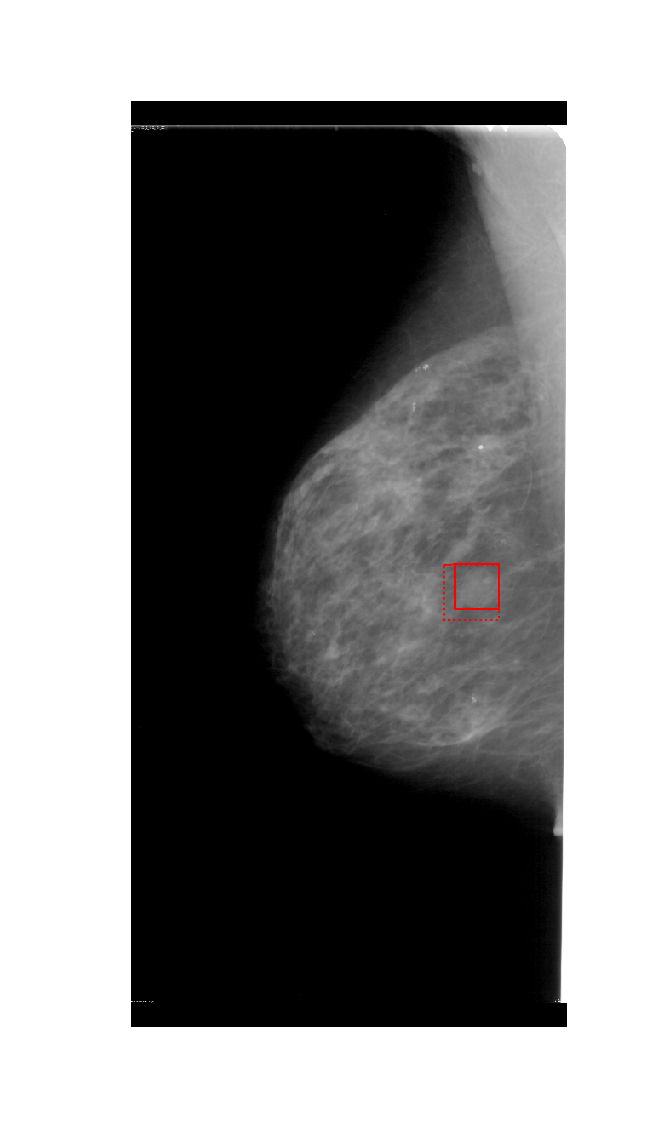

In [13]:
# Display positive anchors before refinement (dotted) and
# after refinement (solid).
visualize.draw_boxes(
    image, ax=get_ax(),
    boxes=positive_anchors,
    refined_boxes=refined_anchors)

### 1.b RPN Predictions

Here we run the RPN graph and display its predictions.

In [14]:
# Run RPN sub-graph
pillar = model.keras_model.get_layer("ROI").output  # node to start searching from

# TF 1.4 introduces a new version of NMS. Search for both names to support TF 1.3 and 1.4
nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression:0")
if nms_node is None:
    nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression/NonMaxSuppressionV2:0")

rpn = model.run_graph(image[np.newaxis], [
    ("rpn_class", model.keras_model.get_layer("rpn_class").output),
    ("pre_nms_anchors", model.ancestor(pillar, "ROI/pre_nms_anchors:0")),
    ("refined_anchors", model.ancestor(pillar, "ROI/refined_anchors:0")),
    ("refined_anchors_clipped", model.ancestor(pillar, "ROI/refined_anchors_clipped:0")),
    ("post_nms_anchor_ix", nms_node),
    ("proposals", model.keras_model.get_layer("ROI").output),
], image_metas=image_meta[np.newaxis])

rpn_class                shape: (1, 139128, 2)        min:    0.00000  max:    1.00000  float32
pre_nms_anchors          shape: (1, 6000, 4)          min:   -0.35425  max:    1.22900  float32
refined_anchors          shape: (1, 6000, 4)          min:   -0.45438  max:    1.30524  float32
refined_anchors_clipped  shape: (1, 6000, 4)          min:    0.00000  max:    1.00000  float32
post_nms_anchor_ix       shape: (1019,)               min:    0.00000  max: 5975.00000  int32
proposals                shape: (1, 3000, 4)          min:    0.00000  max:    1.00000  float32


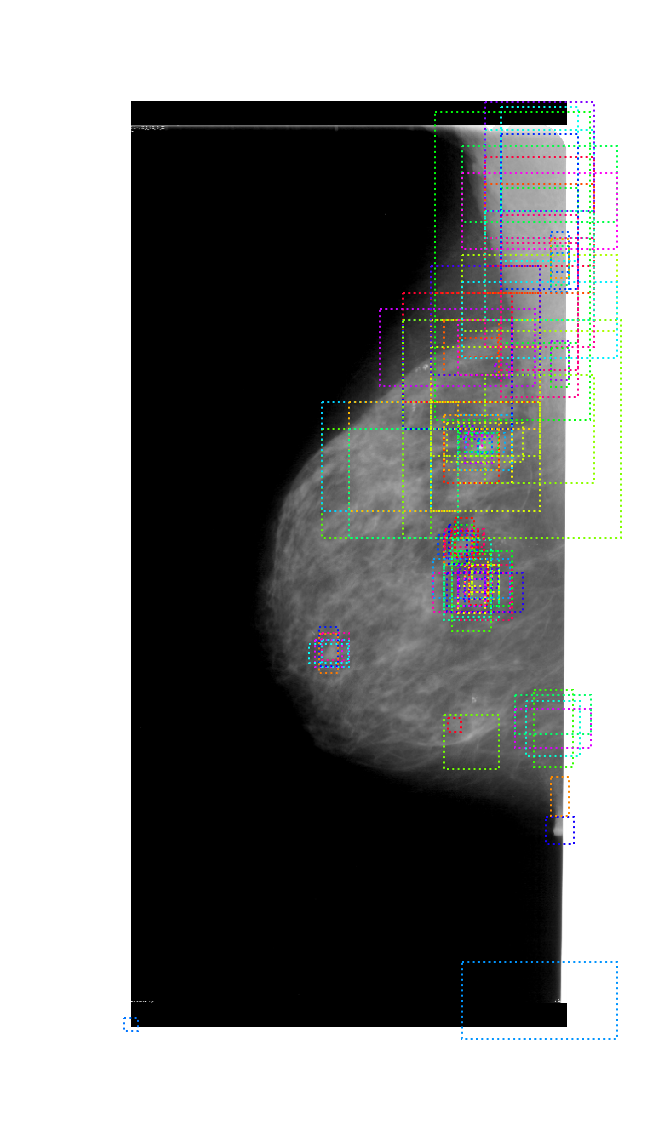

In [15]:
# Show top anchors by score (before refinement)
limit = 100
sorted_anchor_ids = np.argsort(rpn['rpn_class'][:,:,1].flatten())[::-1]
visualize.draw_boxes(image, boxes=anchors[sorted_anchor_ids[:limit]], ax=get_ax())

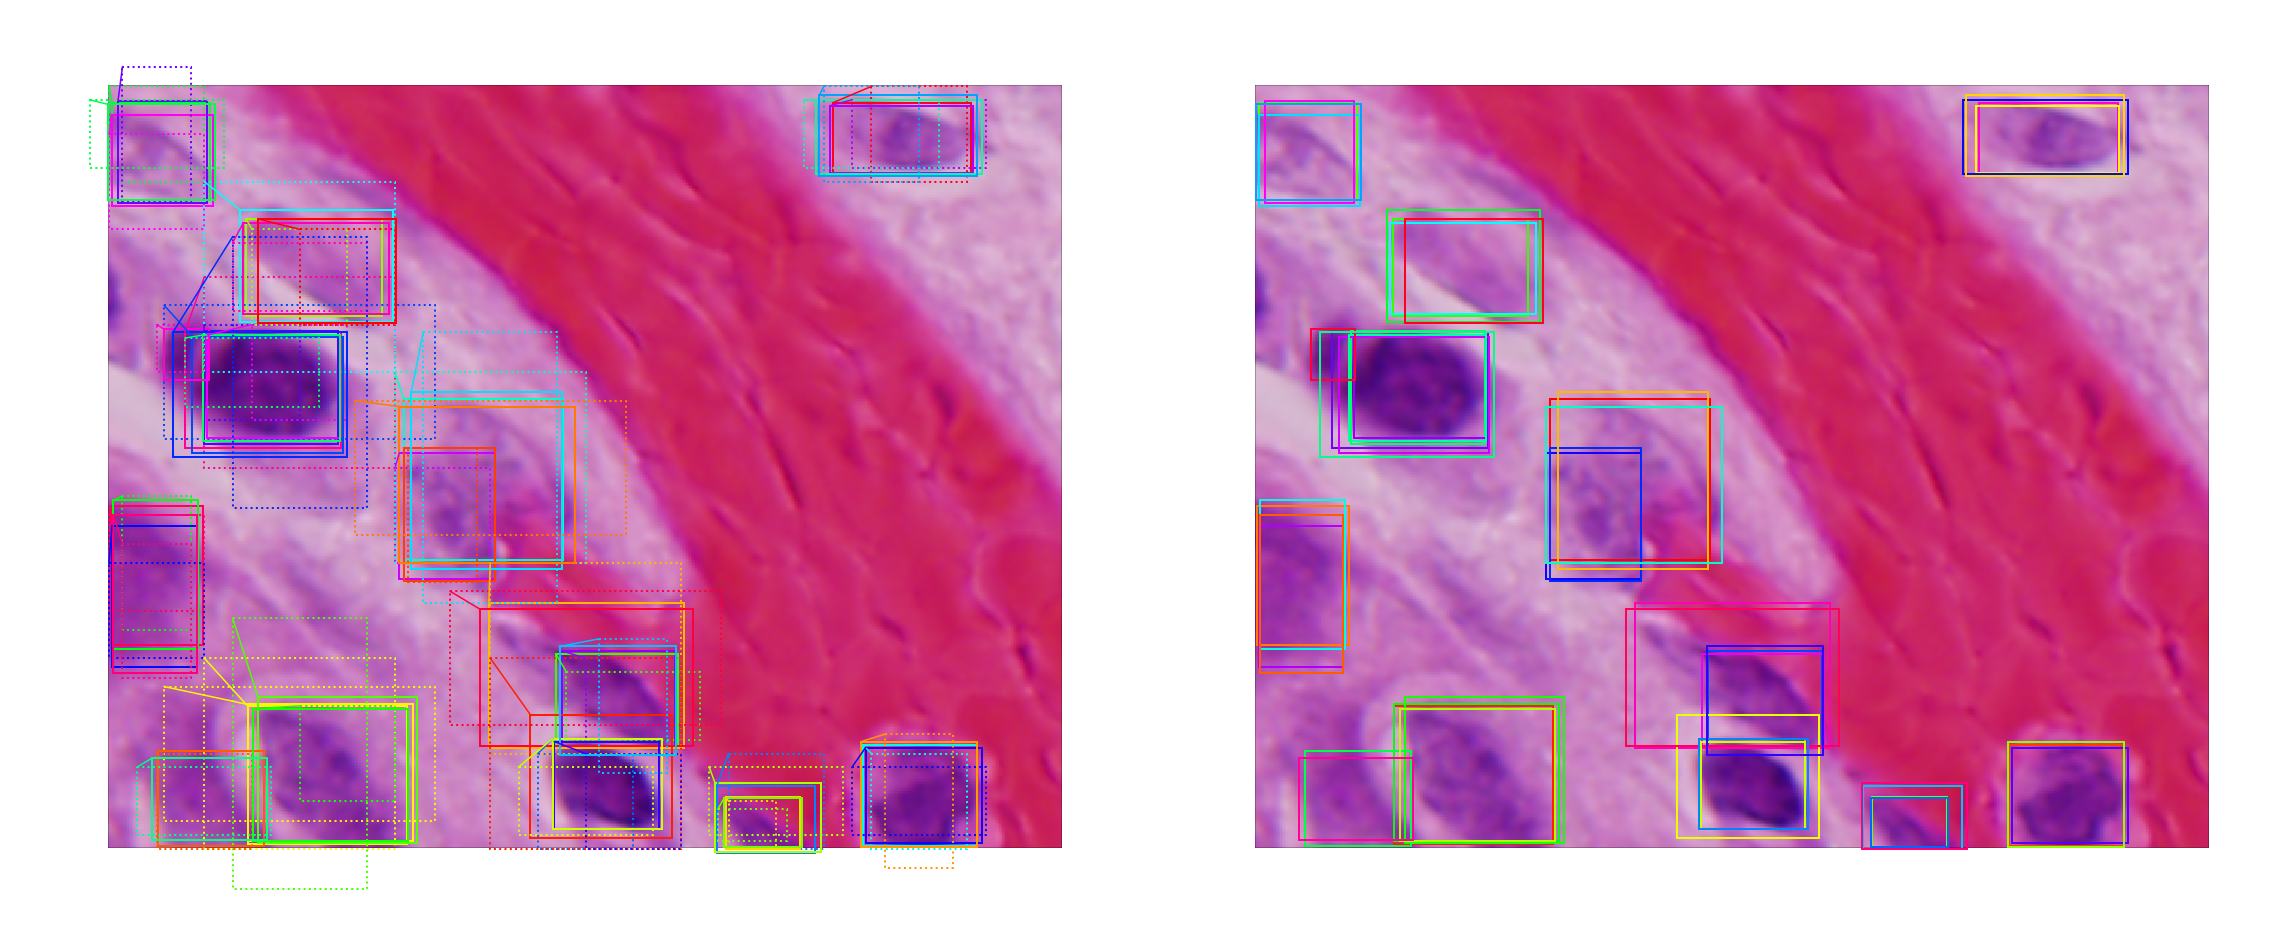

In [17]:
# Show top anchors with refinement. Then with clipping to image boundaries
limit = 50
ax = get_ax(1, 2)
visualize.draw_boxes(
    image, ax=ax[0],
    boxes=utils.denorm_boxes(rpn["pre_nms_anchors"][0, :limit], image.shape[:2]), 
    refined_boxes=utils.denorm_boxes(rpn["refined_anchors"][0, :limit], image.shape[:2]))
visualize.draw_boxes(
    image, ax=ax[1],
    refined_boxes=utils.denorm_boxes(rpn["refined_anchors_clipped"][0, :limit], image.shape[:2]))

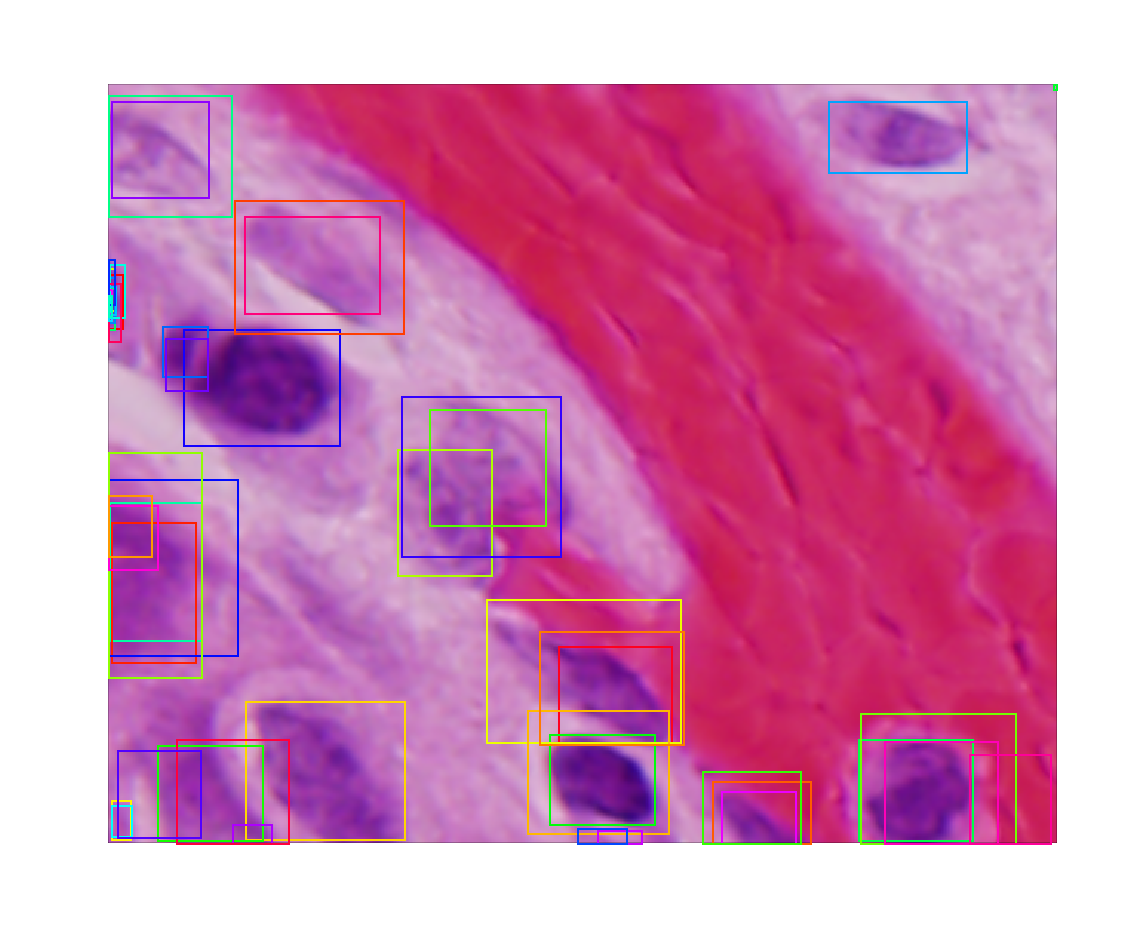

In [18]:
# Show refined anchors after non-max suppression
limit = 50
ixs = rpn["post_nms_anchor_ix"][:limit]
visualize.draw_boxes(
    image, ax=get_ax(),
    refined_boxes=utils.denorm_boxes(rpn["refined_anchors_clipped"][0, ixs], image.shape[:2]))

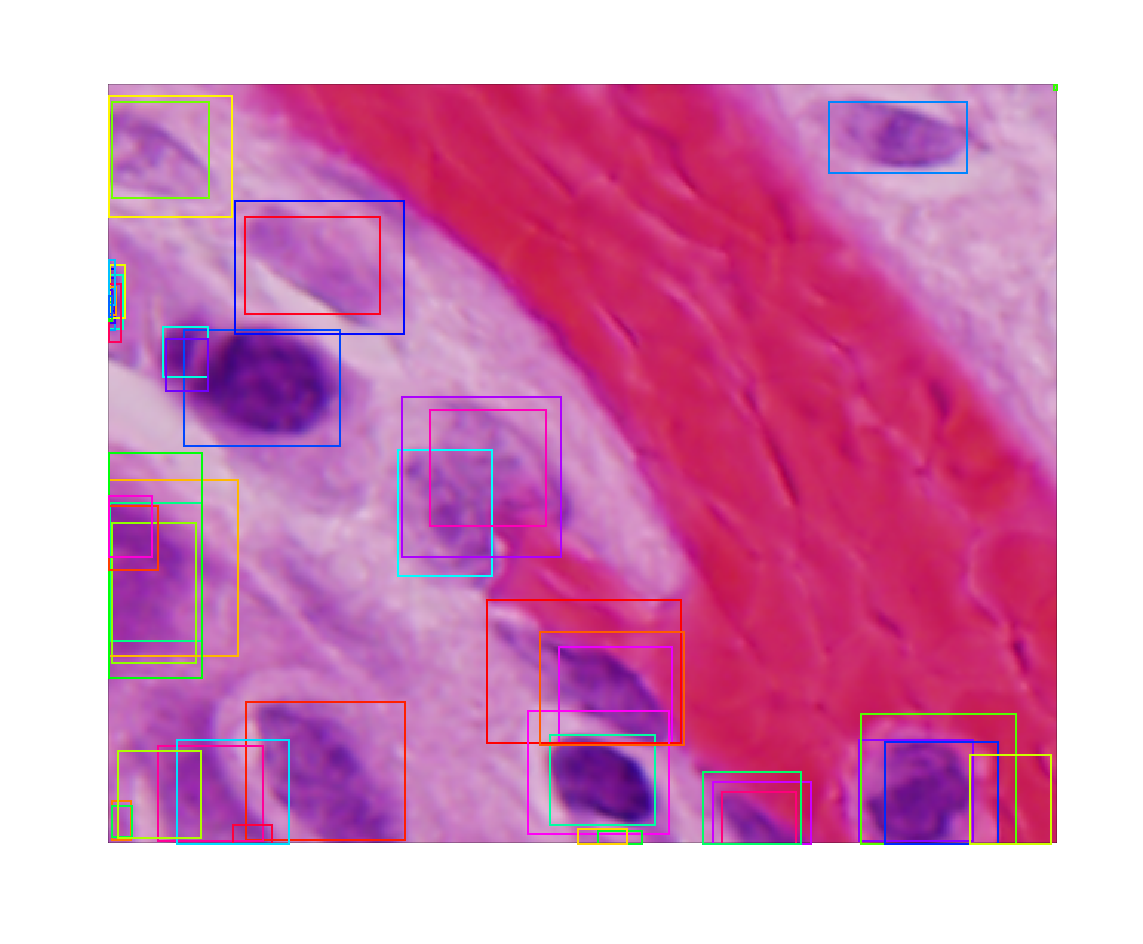

In [19]:
# Show final proposals
# These are the same as the previous step (refined anchors 
# after NMS) but with coordinates normalized to [0, 1] range.
limit = 50
# Convert back to image coordinates for display
# h, w = config.IMAGE_SHAPE[:2]
# proposals = rpn['proposals'][0, :limit] * np.array([h, w, h, w])
visualize.draw_boxes(
    image, ax=get_ax(),
    refined_boxes=utils.denorm_boxes(rpn['proposals'][0, :limit], image.shape[:2]))

## Stage 2: Proposal Classification

This stage takes the region proposals from the RPN and classifies them.

### 2.a Proposal Classification

Run the classifier heads on proposals to generate class propbabilities and bounding box regressions.

In [16]:
# Get input and output to classifier and mask heads.
mrcnn = model.run_graph([image], [
    ("proposals", model.keras_model.get_layer("ROI").output),
    ("probs", model.keras_model.get_layer("mrcnn_class").output),
    ("deltas", model.keras_model.get_layer("mrcnn_bbox").output),
    ("masks", model.keras_model.get_layer("mrcnn_mask").output),
    ("detections", model.keras_model.get_layer("mrcnn_detection").output),
])

proposals                shape: (1, 3000, 4)          min:    0.00000  max:    1.00000  float32
probs                    shape: (1, 3000, 2)          min:    0.00000  max:    1.00000  float32
deltas                   shape: (1, 3000, 2, 4)       min:   -3.49923  max:    3.46118  float32
masks                    shape: (1, 400, 28, 28, 2)   min:    0.00001  max:    1.00000  float32
detections               shape: (1, 400, 6)           min:    0.00000  max:    1.00000  float32


1 detections: ['mass']


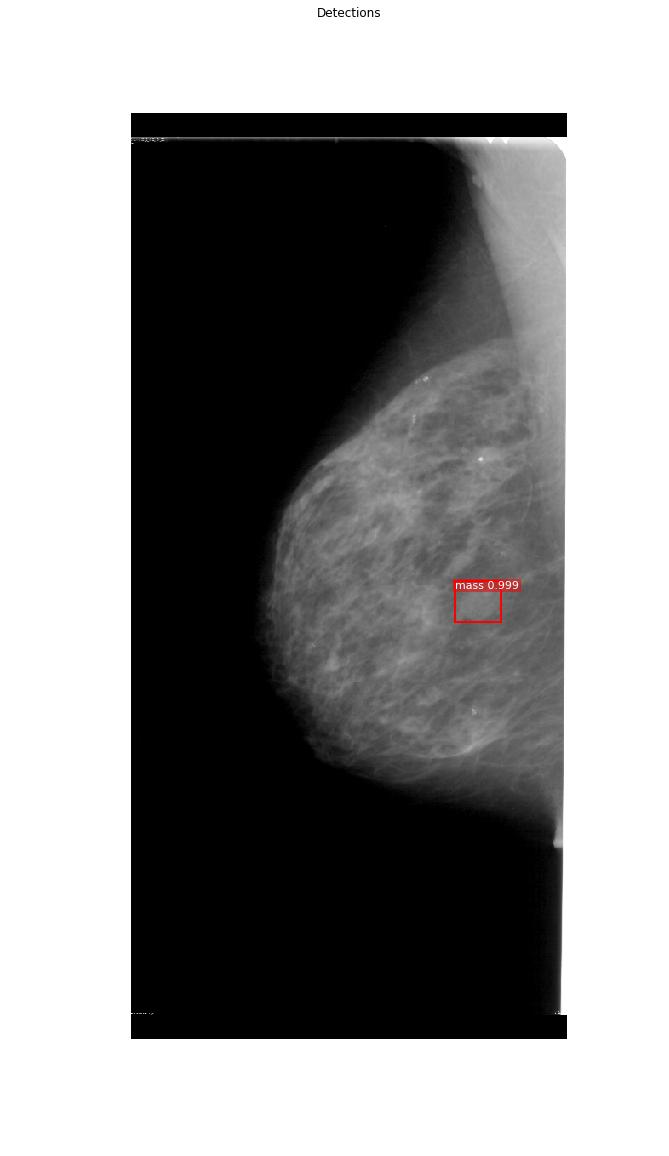

In [18]:
# Get detection class IDs. Trim zero padding.
det_class_ids = mrcnn['detections'][0, :, 4].astype(np.int32)
det_count = np.where(det_class_ids == 0)[0][0]
det_class_ids = det_class_ids[:det_count]
detections = mrcnn['detections'][0, :det_count]

print("{} detections: {}".format(
    det_count, np.array(dataset.class_names)[det_class_ids]))

captions = ["{} {:.3f}".format(dataset.class_names[int(c)], s) if c > 0 else ""
            for c, s in zip(detections[:, 4], detections[:, 5])]
visualize.draw_boxes(
    image, 
    refined_boxes=utils.denorm_boxes(detections[:, :4], image.shape[:2]),
    visibilities=[2] * len(detections),
    captions=captions, title="Detections",
    ax=get_ax())

### 2.c Step by Step Detection

Here we dive deeper into the process of processing the detections.

In [19]:
# Proposals are in normalized coordinates
proposals = mrcnn["proposals"][0]

# Class ID, score, and mask per proposal
roi_class_ids = np.argmax(mrcnn["probs"][0], axis=1)
roi_scores = mrcnn["probs"][0, np.arange(roi_class_ids.shape[0]), roi_class_ids]
roi_class_names = np.array(dataset.class_names)[roi_class_ids]
roi_positive_ixs = np.where(roi_class_ids > 0)[0]

# How many ROIs vs empty rows?
print("{} Valid proposals out of {}".format(np.sum(np.any(proposals, axis=1)), proposals.shape[0]))
print("{} Positive ROIs".format(len(roi_positive_ixs)))

# Class counts
print(list(zip(*np.unique(roi_class_names, return_counts=True))))

996 Valid proposals out of 3000
2 Positive ROIs
[('BG', 2998), ('mass', 2)]


In [20]:
# Proposals are in normalized coordinates
proposals = mrcnn["proposals"][0]

# Class ID, score, and mask per proposal
roi_class_ids = np.argmax(mrcnn["probs"][0], axis=1)
roi_scores = mrcnn["probs"][0, np.arange(roi_class_ids.shape[0]), roi_class_ids]
roi_class_names = np.array(dataset.class_names)[roi_class_ids]
roi_positive_ixs = np.where(roi_class_ids > 0)[0]

# How many ROIs vs empty rows?
print("{} Valid proposals out of {}".format(np.sum(np.any(proposals, axis=1)), proposals.shape[0]))
print("{} Positive ROIs".format(len(roi_positive_ixs)))

# Class counts
print(list(zip(*np.unique(roi_class_names, return_counts=True))))

996 Valid proposals out of 3000
2 Positive ROIs
[('BG', 2998), ('mass', 2)]


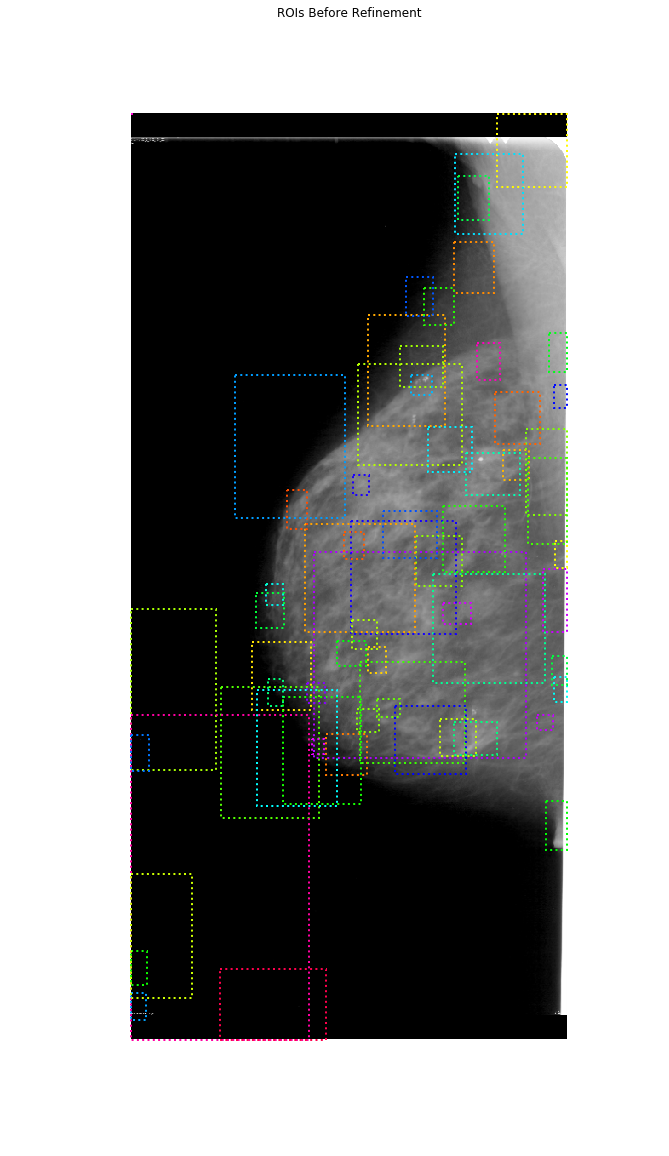

In [21]:
# Display a random sample of proposals.
# Proposals classified as background are dotted, and
# the rest show their class and confidence score.
limit = 200
ixs = np.random.randint(0, proposals.shape[0], limit)
captions = ["{} {:.3f}".format(dataset.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[ixs], roi_scores[ixs])]
visualize.draw_boxes(
    image,
    boxes=utils.denorm_boxes(proposals[ixs], image.shape[:2]),
    visibilities=np.where(roi_class_ids[ixs] > 0, 2, 1),
    captions=captions, title="ROIs Before Refinement",
    ax=get_ax())

roi_bbox_specific        shape: (3000, 4)             min:   -4.09624  max:    3.27091  float32
refined_proposals        shape: (3000, 4)             min:   -0.00942  max:    1.03418  float32


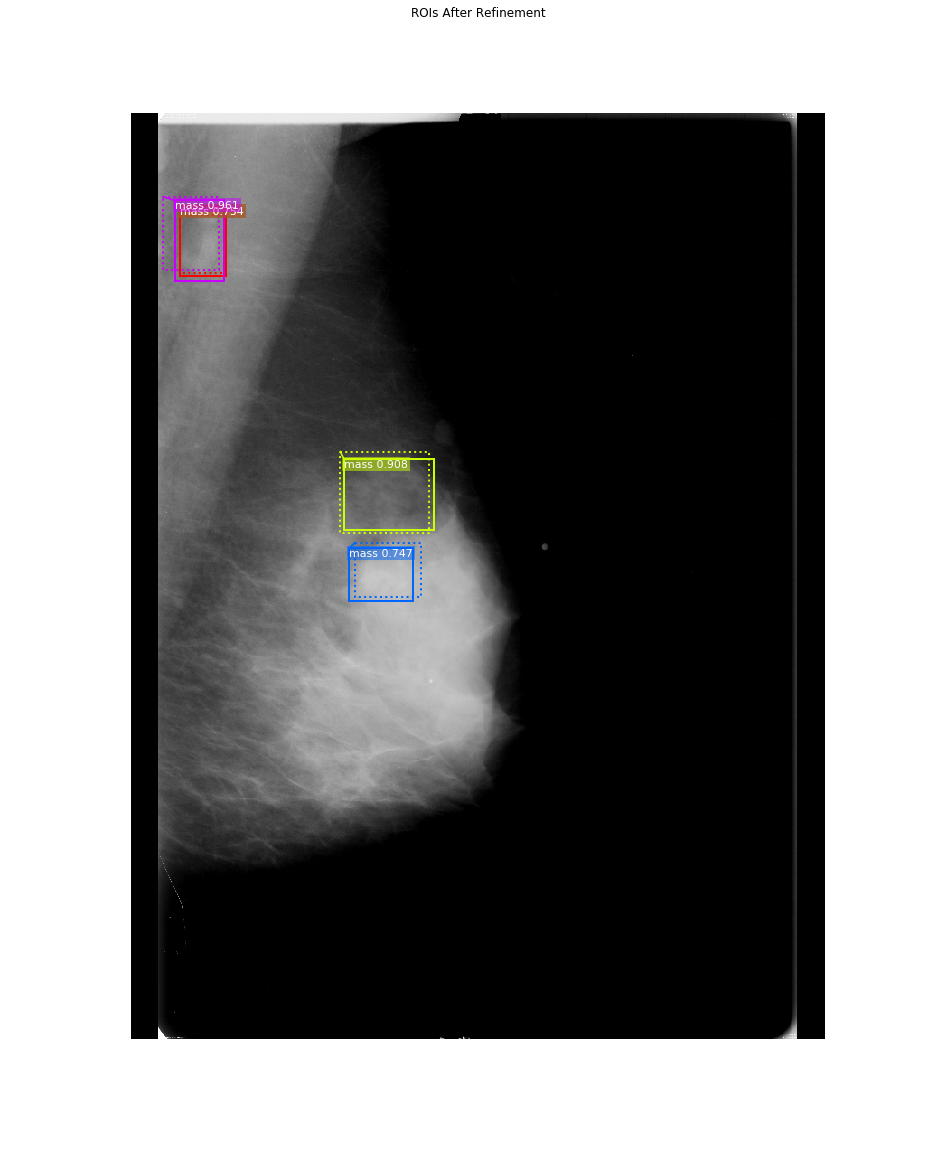

In [30]:
# Class-specific bounding box shifts.
roi_bbox_specific = mrcnn["deltas"][0, np.arange(proposals.shape[0]), roi_class_ids]
log("roi_bbox_specific", roi_bbox_specific)

# Apply bounding box transformations
# Shape: [N, (y1, x1, y2, x2)]
refined_proposals = utils.apply_box_deltas(
    proposals, roi_bbox_specific * config.BBOX_STD_DEV)
log("refined_proposals", refined_proposals)

# Show positive proposals
# ids = np.arange(roi_boxes.shape[0])  # Display all
limit = 5
ids = np.random.randint(0, len(roi_positive_ixs), limit)  # Display random sample
captions = ["{} {:.3f}".format(dataset.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[roi_positive_ixs][ids], roi_scores[roi_positive_ixs][ids])]
visualize.draw_boxes(
    image, ax=get_ax(),
    boxes=utils.denorm_boxes(proposals[roi_positive_ixs][ids], image.shape[:2]),
    refined_boxes=utils.denorm_boxes(refined_proposals[roi_positive_ixs][ids], image.shape[:2]),
    visibilities=np.where(roi_class_ids[roi_positive_ixs][ids] > 0, 1, 0),
    captions=captions, title="ROIs After Refinement")

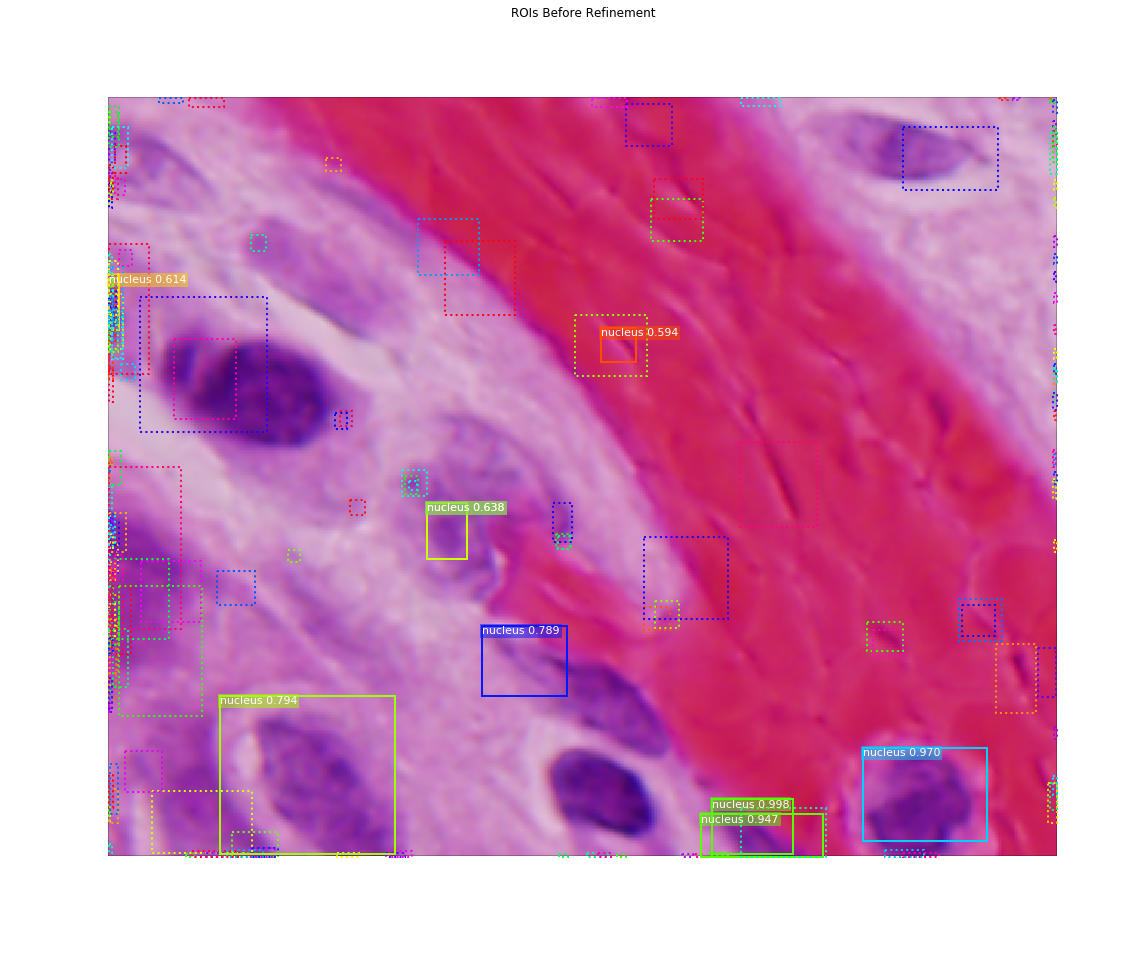

In [23]:
# Display a random sample of proposals.
# Proposals classified as background are dotted, and
# the rest show their class and confidence score.
limit = 200
ixs = np.random.randint(0, proposals.shape[0], limit)
captions = ["{} {:.3f}".format(dataset.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[ixs], roi_scores[ixs])]
visualize.draw_boxes(
    image,
    boxes=utils.denorm_boxes(proposals[ixs], image.shape[:2]),
    visibilities=np.where(roi_class_ids[ixs] > 0, 2, 1),
    captions=captions, title="ROIs Before Refinement",
    ax=get_ax())

#### Apply Bounding Box Refinement

roi_bbox_specific        shape: (2000, 4)             min:   -2.55332  max:    3.38944  float32
refined_proposals        shape: (2000, 4)             min:   -0.00621  max:    1.06598  float32


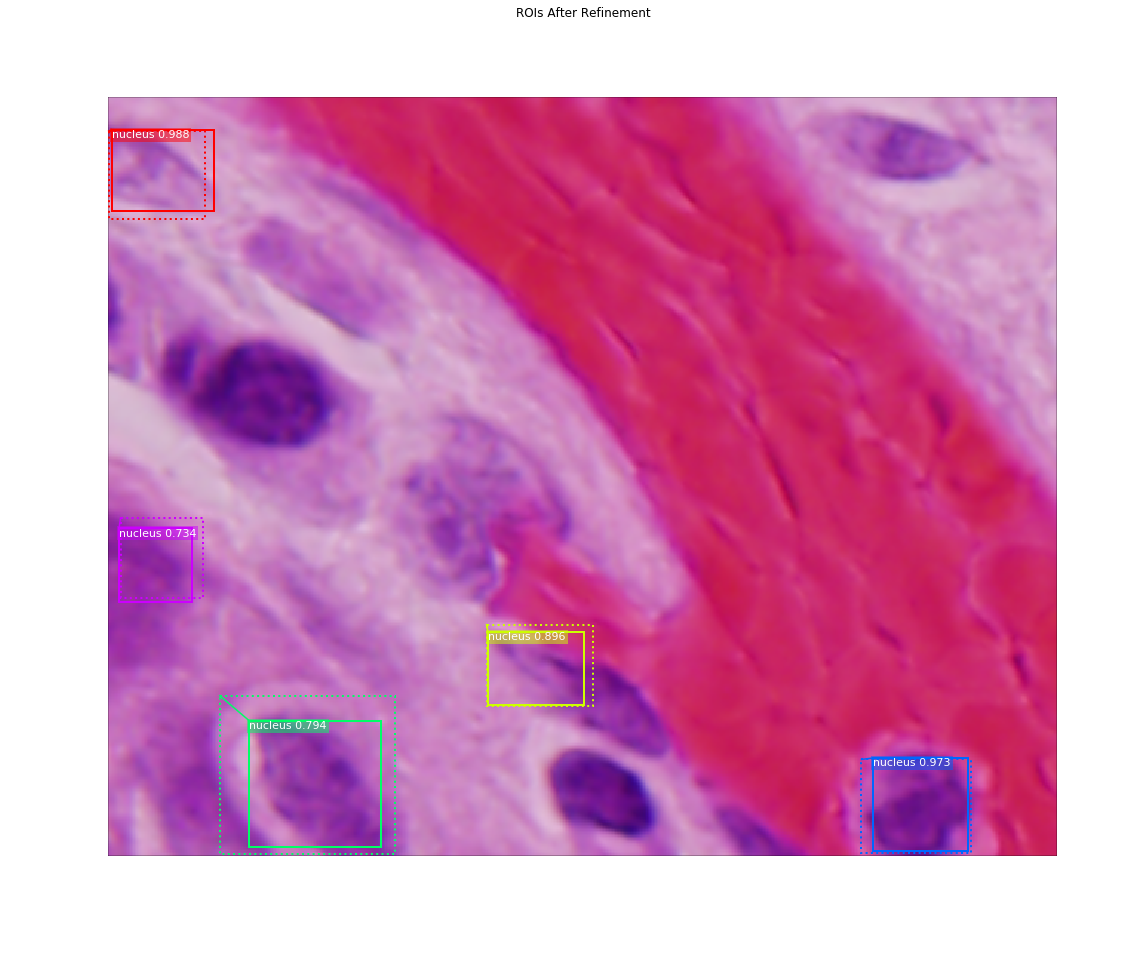

In [24]:
# Class-specific bounding box shifts.
roi_bbox_specific = mrcnn["deltas"][0, np.arange(proposals.shape[0]), roi_class_ids]
log("roi_bbox_specific", roi_bbox_specific)

# Apply bounding box transformations
# Shape: [N, (y1, x1, y2, x2)]
refined_proposals = utils.apply_box_deltas(
    proposals, roi_bbox_specific * config.BBOX_STD_DEV)
log("refined_proposals", refined_proposals)

# Show positive proposals
# ids = np.arange(roi_boxes.shape[0])  # Display all
limit = 5
ids = np.random.randint(0, len(roi_positive_ixs), limit)  # Display random sample
captions = ["{} {:.3f}".format(dataset.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[roi_positive_ixs][ids], roi_scores[roi_positive_ixs][ids])]
visualize.draw_boxes(
    image, ax=get_ax(),
    boxes=utils.denorm_boxes(proposals[roi_positive_ixs][ids], image.shape[:2]),
    refined_boxes=utils.denorm_boxes(refined_proposals[roi_positive_ixs][ids], image.shape[:2]),
    visibilities=np.where(roi_class_ids[roi_positive_ixs][ids] > 0, 1, 0),
    captions=captions, title="ROIs After Refinement")

#### Filter Low Confidence Detections

In [31]:
# Remove boxes classified as background
keep = np.where(roi_class_ids > 0)[0]
print("Keep {} detections:\n{}".format(keep.shape[0], keep))

Keep 8 detections:
[  1   2   4   5  11  13  14 121]


In [32]:
# Remove low confidence detections
keep = np.intersect1d(keep, np.where(roi_scores >= config.DETECTION_MIN_CONFIDENCE)[0])
print("Remove boxes below {} confidence. Keep {}:\n{}".format(
    config.DETECTION_MIN_CONFIDENCE, keep.shape[0], keep))

Remove boxes below 0.5 confidence. Keep 8:
[  1   2   4   5  11  13  14 121]


#### Per-Class Non-Max Suppression

In [33]:
# Apply per-class non-max suppression
pre_nms_boxes = refined_proposals[keep]
pre_nms_scores = roi_scores[keep]
pre_nms_class_ids = roi_class_ids[keep]

nms_keep = []
for class_id in np.unique(pre_nms_class_ids):
    # Pick detections of this class
    ixs = np.where(pre_nms_class_ids == class_id)[0]
    # Apply NMS
    class_keep = utils.non_max_suppression(pre_nms_boxes[ixs], 
                                            pre_nms_scores[ixs],
                                            config.DETECTION_NMS_THRESHOLD)
    # Map indicies
    class_keep = keep[ixs[class_keep]]
    nms_keep = np.union1d(nms_keep, class_keep)
    print("{:22}: {} -> {}".format(dataset.class_names[class_id][:20], 
                                   keep[ixs], class_keep))

keep = np.intersect1d(keep, nms_keep).astype(np.int32)
print("\nKept after per-class NMS: {}\n{}".format(keep.shape[0], keep))

mass                  : [  1   2   4   5  11  13  14 121] -> [  2 121  11   4  13   5]

Kept after per-class NMS: 6
[  2   4   5  11  13 121]


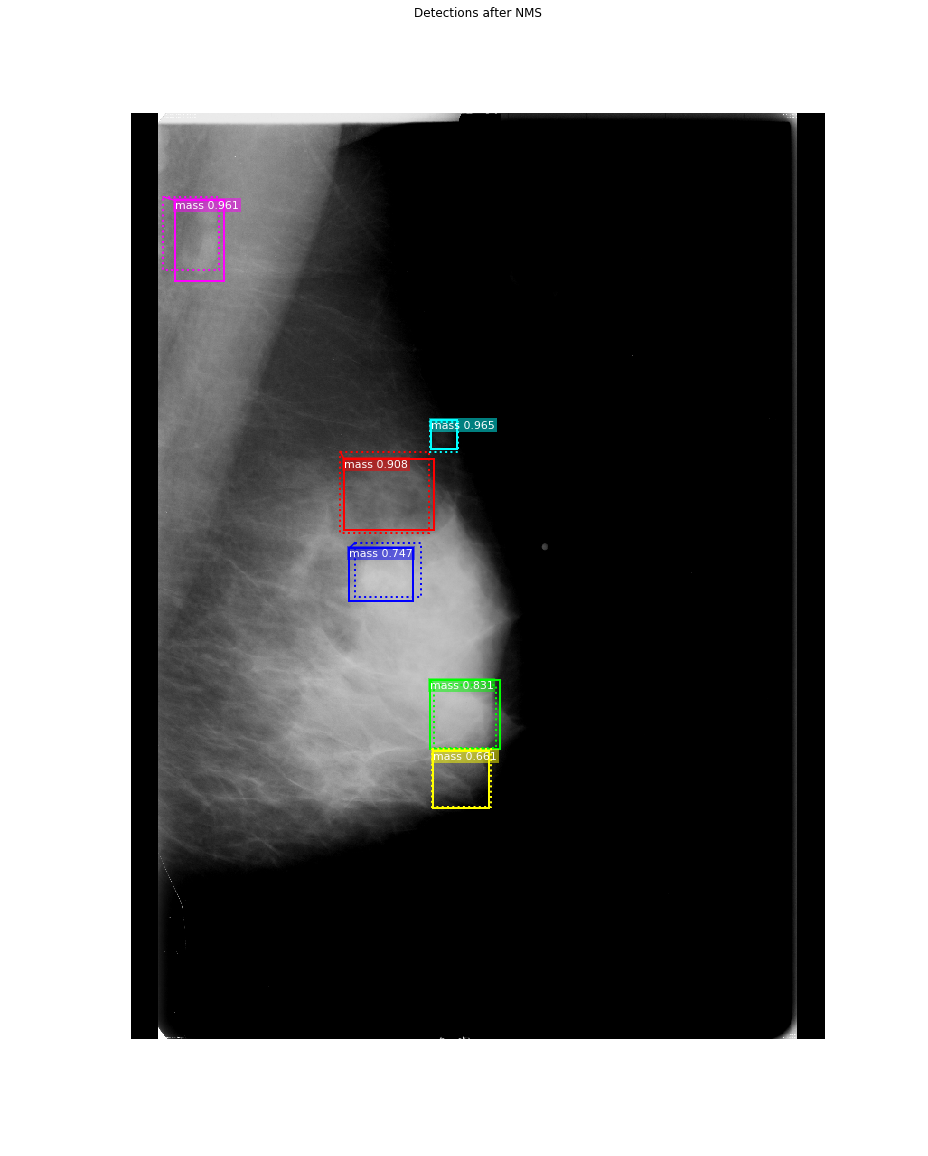

In [34]:
# Show final detections
ixs = np.arange(len(keep))  # Display all
# ixs = np.random.randint(0, len(keep), 10)  # Display random sample
captions = ["{} {:.3f}".format(dataset.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[keep][ixs], roi_scores[keep][ixs])]
visualize.draw_boxes(
    image,
    boxes=utils.denorm_boxes(proposals[keep][ixs], image.shape[:2]),
    refined_boxes=utils.denorm_boxes(refined_proposals[keep][ixs], image.shape[:2]),
    visibilities=np.where(roi_class_ids[keep][ixs] > 0, 1, 0),
    captions=captions, title="Detections after NMS",
    ax=get_ax())

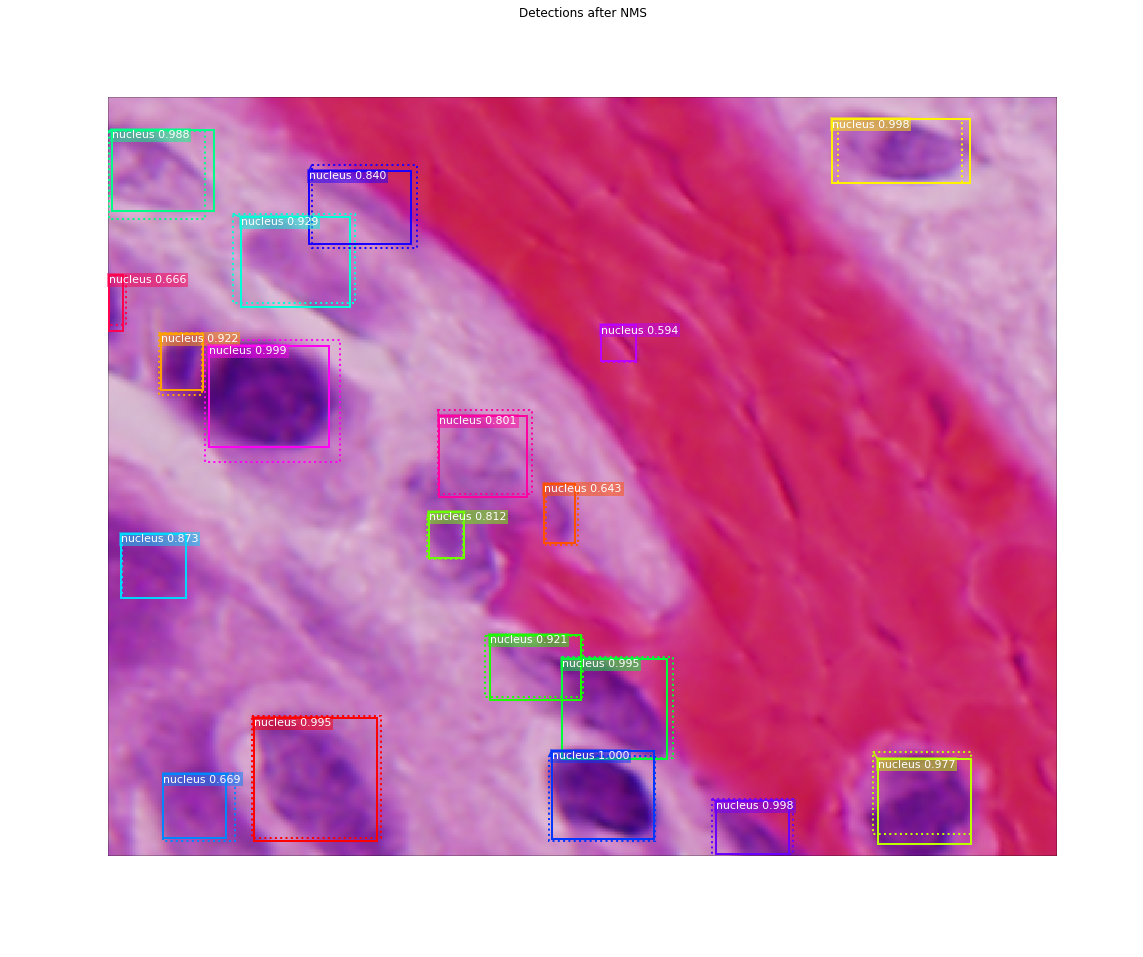

In [28]:
# Show final detections
ixs = np.arange(len(keep))  # Display all
# ixs = np.random.randint(0, len(keep), 10)  # Display random sample
captions = ["{} {:.3f}".format(dataset.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[keep][ixs], roi_scores[keep][ixs])]
visualize.draw_boxes(
    image,
    boxes=utils.denorm_boxes(proposals[keep][ixs], image.shape[:2]),
    refined_boxes=utils.denorm_boxes(refined_proposals[keep][ixs], image.shape[:2]),
    visibilities=np.where(roi_class_ids[keep][ixs] > 0, 1, 0),
    captions=captions, title="Detections after NMS",
    ax=get_ax())

## Stage 3: Generating Masks

This stage takes the detections (refined bounding boxes and class IDs) from the previous layer and runs the mask head to generate segmentation masks for every instance.

### 3.a Mask Targets

These are the training targets for the mask branch

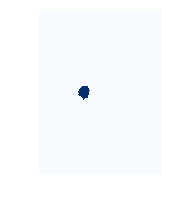

In [35]:
limit = 8
display_images(np.transpose(gt_mask[..., :limit], [2, 0, 1]), cmap="Blues")

### 3.b Predicted Masks

In [36]:
# Get predictions of mask head
mrcnn = model.run_graph([image], [
    ("detections", model.keras_model.get_layer("mrcnn_detection").output),
    ("masks", model.keras_model.get_layer("mrcnn_mask").output),
])

# Get detection class IDs. Trim zero padding.
det_class_ids = mrcnn['detections'][0, :, 4].astype(np.int32)
det_count = np.where(det_class_ids == 0)[0][0]
det_class_ids = det_class_ids[:det_count]

print("{} detections: {}".format(
    det_count, np.array(dataset.class_names)[det_class_ids]))

detections               shape: (1, 400, 6)           min:    0.00000  max:    1.00000  float32
masks                    shape: (1, 400, 28, 28, 2)   min:    0.00017  max:    1.00000  float32
6 detections: ['mass' 'mass' 'mass' 'mass' 'mass' 'mass']


In [37]:
# Masks
det_boxes = utils.denorm_boxes(mrcnn["detections"][0, :, :4], image.shape[:2])
det_mask_specific = np.array([mrcnn["masks"][0, i, :, :, c] 
                              for i, c in enumerate(det_class_ids)])
det_masks = np.array([utils.unmold_mask(m, det_boxes[i], image.shape)
                      for i, m in enumerate(det_mask_specific)])
log("det_mask_specific", det_mask_specific)
log("det_masks", det_masks)

det_mask_specific        shape: (6, 28, 28)           min:    0.00017  max:    1.00000  float32
det_masks                shape: (6, 1024, 768)        min:    0.00000  max:    1.00000  bool


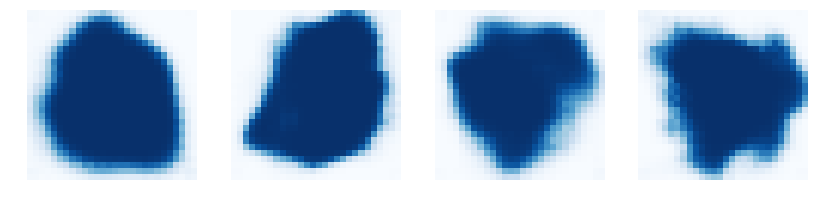

In [38]:
display_images(det_mask_specific[:4] * 255, cmap="Blues", interpolation="none")

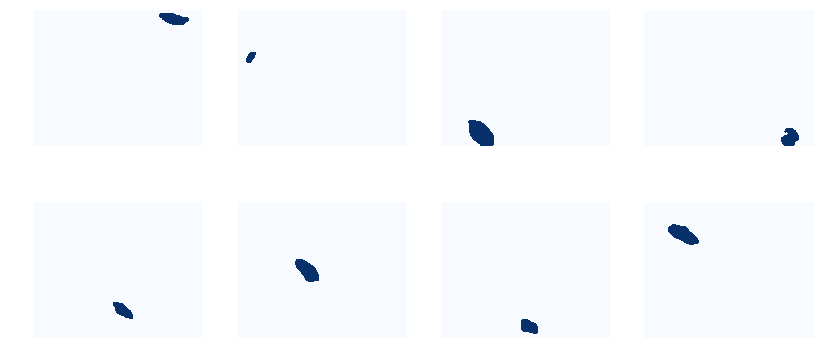

In [29]:
limit = 8
display_images(np.transpose(gt_mask[..., :limit], [2, 0, 1]), cmap="Blues")

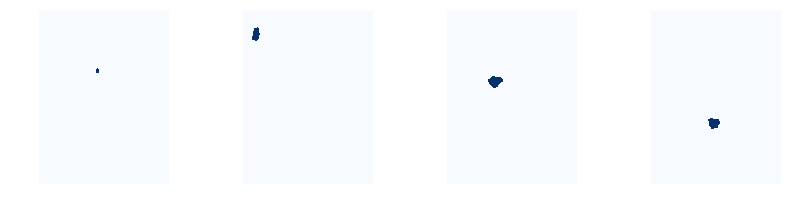

In [39]:
display_images(det_masks[:4] * 255, cmap="Blues", interpolation="none")

## Visualize Activations

In some cases it helps to look at the output from different layers and visualize them to catch issues and odd patterns.

In [40]:
# Get activations of a few sample layers
activations = model.run_graph([image], [
    ("input_image",        model.keras_model.get_layer("input_image").output),
    ("res2c_out",          model.keras_model.get_layer("res2c_out").output),
    ("res3c_out",          model.keras_model.get_layer("res3c_out").output),
    ("rpn_bbox",           model.keras_model.get_layer("rpn_bbox").output),
    ("roi",                model.keras_model.get_layer("ROI").output),
])

input_image              shape: (1, 1024, 768, 3)     min:  -54.78000  max:  200.22000  float32
res2c_out                shape: (1, 256, 192, 256)    min:    0.00000  max:   18.20702  float32
res3c_out                shape: (1, 128, 96, 512)     min:    0.00000  max:   24.06776  float32
rpn_bbox                 shape: (1, 196416, 4)        min:  -12.87761  max:   36.05722  float32
roi                      shape: (1, 3000, 4)          min:    0.00000  max:    1.00000  float32


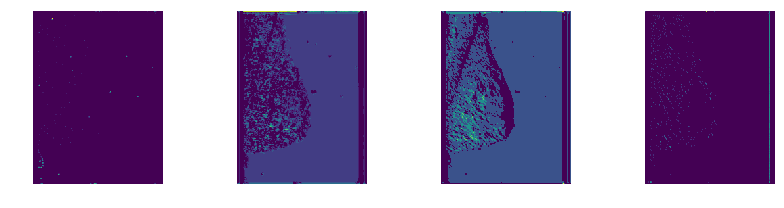

In [41]:
# Backbone feature map
display_images(np.transpose(activations["res2c_out"][0,:,:,:4], [2, 0, 1]), cols=4)

In [34]:
# Get activations of a few sample layers
activations = model.run_graph([image], [
    ("input_image",        model.keras_model.get_layer("input_image").output),
    ("res2c_out",          model.keras_model.get_layer("res2c_out").output),
    ("res3c_out",          model.keras_model.get_layer("res3c_out").output),
    ("rpn_bbox",           model.keras_model.get_layer("rpn_bbox").output),
    ("roi",                model.keras_model.get_layer("ROI").output),
])

input_image              shape: (1, 1024, 1280, 3)    min:  -38.56000  max:  184.47000  float32
res2c_out                shape: (1, 256, 320, 256)    min:    0.00000  max:   18.96384  float32
res3c_out                shape: (1, 128, 160, 512)    min:    0.00000  max:   14.29902  float32
rpn_bbox                 shape: (1, 327360, 4)        min:  -14.41855  max:   60.67371  float32
roi                      shape: (1, 2000, 4)          min:    0.00000  max:    1.00000  float32


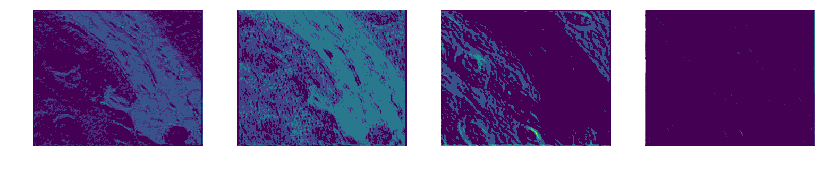

In [35]:
# Backbone feature map
display_images(np.transpose(activations["res2c_out"][0,:,:,:4], [2, 0, 1]), cols=4)